# Mice Protein Gene Expression

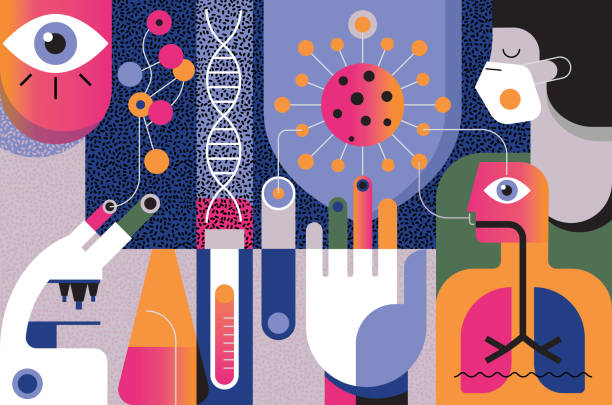

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import f_oneway, ttest_ind
from itertools import combinations


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-03-27 18:19:21.302302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Cleaning the Dataset

In [2]:
mice1 = '../cortical_protein_expression//mice_gene_dataset/Data_Cortex_Nuclear.csv'
mice2 = '../cortical_protein_expression//mice_gene_dataset/Data_Cortex_Nuclear2.csv'

# List of input CSV file names
input_mice = [mice1, mice2]

# Read each CSV file into a DataFrame
dfs_mice = [pd.read_csv(file) for file in input_mice]

# Concatenate the DataFrames
concat_mice = pd.concat(dfs_mice)


In [3]:
print(concat_mice.isnull().sum().sort_values(ascending = False).head(10), '\n', '\n')
print(concat_mice.head(), '\n', '\n')
print('Shape of original dataset is', concat_mice.shape)


BCL2_N        570
H3MeK4_N      540
BAD_N         426
EGR1_N        420
H3AcK18_N     360
pCFOS_N       150
ELK_N          36
Bcatenin_N     36
MEK_N          14
P38_N           6
dtype: int64 
 

  MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0   309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1   309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2   309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3   309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4   309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   

    pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0  0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1  0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2  0.175722   2.283337  0.230247  ...  0.106219  0.435777   0.111883   
3  0.176463   2.152301  0.207004  ...  0.111262  0.391691   0.130405   
4  0

In [4]:
# Identify columns with more than 75 missing values
nmice_col = concat_mice.dropna(axis = 1, thresh = len(concat_mice) - 75)
nmice = nmice_col.dropna(axis = 0)


In [5]:
subset_cols = nmice.loc[:, 'DYRK1A_N':'CaNA_N']
class_col = nmice['class']

# Group by 'class' and sum the values
class_mean = subset_cols.groupby(class_col).mean()
class_mean


DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
class                                                                          
c-CS-m  0.480456  0.652587  0.339217  2.381749  4.308540  0.229932  0.182211   
c-CS-s  0.613559  0.790434  0.342316  2.417971  4.315746  0.219666  0.173684   
c-SC-m  0.273203  0.436361  0.290946  2.145633  3.459416  0.241253  0.189547   
c-SC-s  0.276882  0.455166  0.307163  2.413561  3.839742  0.232721  0.185501   
t-CS-m  0.619294  0.797007  0.312732  2.196541  3.565960  0.213621  0.173956   
t-CS-s  0.525735  0.759556  0.305460  2.184606  3.514839  0.214466  0.164795   
t-SC-m  0.329861  0.566783  0.321063  2.379446  4.056223  0.269131  0.201007   
t-SC-s  0.337488  0.549056  0.325586  2.248742  3.565093  0.246759  0.185318   

        pCAMKII_N   pCREB_N    pELK_N  ...   P3525_N  pCASP9_N   PSD95_N  \
class                                  ...                                 
c-CS-m   2.916187  0.198484  1.492318  ...  0.298304  1.523643  2.141426   
c-CS-s   2.966158  0.209055  1.717638  ...  0.284027  1.533783  2.071600   
c-SC-m   4.736327  0.208149  1.278566  ...  0.277210  1.638506  2.347967   
c-SC-s   3.124186  0.216793  1.363064  ...  0.287231  1.546037  2.378148   
t-CS-m   3.121801  0.203395  1.563905  ...  0.279923  1.458555  2.218521   
t-CS-s   2.488902  0.210041  1.518302  ...  0.299631  1.491736  2.162338   
t-SC-m   4.277257  0.231789  1.381516  ...  0.285037  1.674924  2.377323   
t-SC-s   4.176555  0.227165  1.204840  ...  0.314150  1.540418  2.182826   

          SNCA_N  Ubiquitin_N  pGSK3B_Tyr216_N     SHH_N     pS6_N     SYP_N  \
class                                                                          
c-CS-m  0.152442     1.177900         0.866693  0.226911  0.119782  0.467403   
c-CS-s  0.146604     1.070902         0.844144  0.211771  0.111999  0.445841   
c-SC-m  0.177103     1.403618         0.825483  0.224470  0.128108  0.456874   
c-SC-s  0.174709     1.265724         0.802973  0.242129  0.133092  0.466560   
t-CS-m  0.138106     1.086861         0.881975  0.216934  0.108196  0.413597   
t-CS-s  0.153577     1.193752         0.839139  0.222144  0.111354  0.433587   
t-SC-m  0.177276     1.415991         0.834239  0.230667  0.137287  0.445738   
t-SC-s  0.157634     1.279150         0.878875  0.235643  0.119205  0.428424   

          CaNA_N  
class             
c-CS-m  1.523659  
c-CS-s  1.635900  
c-SC-m  1.009957  
c-SC-s  1.153488  
t-CS-m  1.633341  
t-CS-s  1.552633  
t-SC-m  1.041134  
t-SC-s  1.224570  

[8 rows x 71 columns]

## Exploration of Variation in Gene Data

#### Analyzing the clustering behavior of protein expression for each experimental condition

In [6]:
sections = {}

for i, condition in enumerate(nmice['class'].unique()):
    sections[i] = nmice[nmice['class'] == condition]
    

In [7]:
for i in range(len(nmice['class'].unique())):
    print('Condition', i+1, '=', sections[i].iloc[:, 75].head(1))


Condition 1 = 0    c-CS-m
Name: class, dtype: object
Condition 2 = 150    c-SC-m
Name: class, dtype: object
Condition 3 = 300    c-CS-s
Name: class, dtype: object
Condition 4 = 435    c-SC-s
Name: class, dtype: object
Condition 5 = 570    t-CS-m
Name: class, dtype: object
Condition 6 = 705    t-SC-m
Name: class, dtype: object
Condition 7 = 840    t-CS-s
Name: class, dtype: object
Condition 8 = 945    t-SC-s
Name: class, dtype: object


In [8]:
features = {}
classes = {}

for i in range(len(nmice['class'].unique())):
    features[i] = sections[i].loc[:, 'DYRK1A_N':'CaNA_N']
    classes[i] = sections[i]['class']


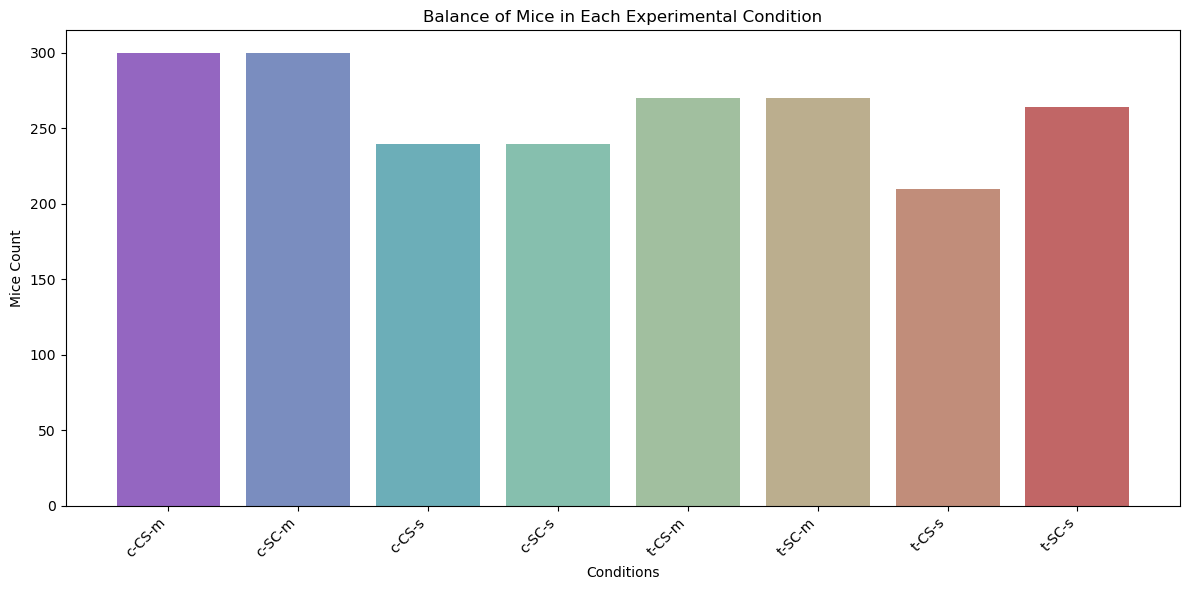

In [9]:
num_rows = []
section_indices = []

for i in range(len(sections)):
    num_rows.append(sections[i].shape[0])
    section_indices.append(classes[i].unique()[0])
    
# Define a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(section_indices)))
lighter_colors = colors * 0.6

plt.figure(figsize=(12, 6))
bars = plt.bar(section_indices, num_rows, color=lighter_colors)

plt.xlabel('Conditions')
plt.ylabel('Mice Count')
plt.title('Balance of Mice in Each Experimental Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Creating Hierarchical Clustering Links

In [10]:
def hierarchical_clustering(data, threshold):
    
    # Compute linkage matrix
    Z = linkage(data, method='ward')
    
    # Perform clustering based on the threshold
    cluster_assignments = fcluster(Z, threshold, criterion='distance')
    
    return Z, cluster_assignments


In [11]:
# Extract features from your dataset
X_imp = features[0]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z, cluster_assignments = hierarchical_clustering(X_imp, threshold)


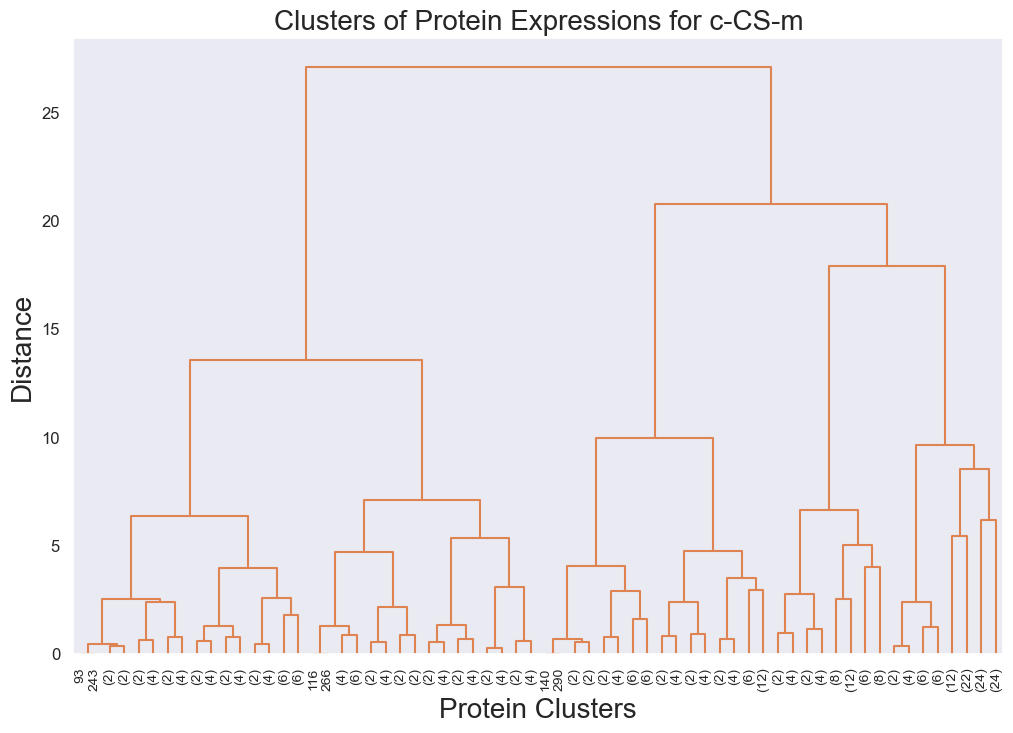

In [87]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions for c-CS-m', fontsize = 20)
plt.xlabel('Protein Clusters', fontsize = 20)
plt.ylabel('Distance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.grid(False)
plt.show()


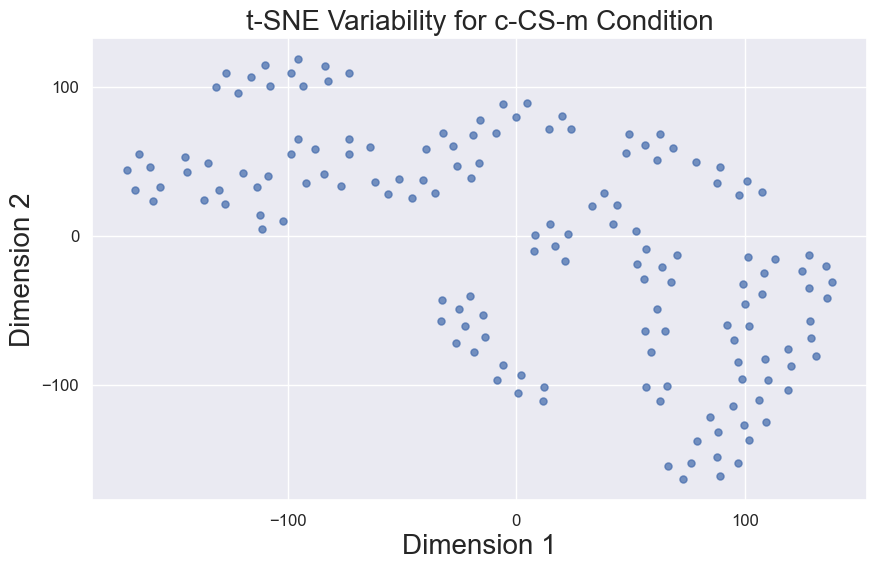

In [86]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(X_imp)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Variability for c-CS-m Condition', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 20)
plt.ylabel('Dimension 2', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


In [14]:
# making a heatmap of the correlation between each protein expression

def plot_corr(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize = (50, 25))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, square=True, cbar_kws={'shrink': .9}, ax=ax, annot=False)


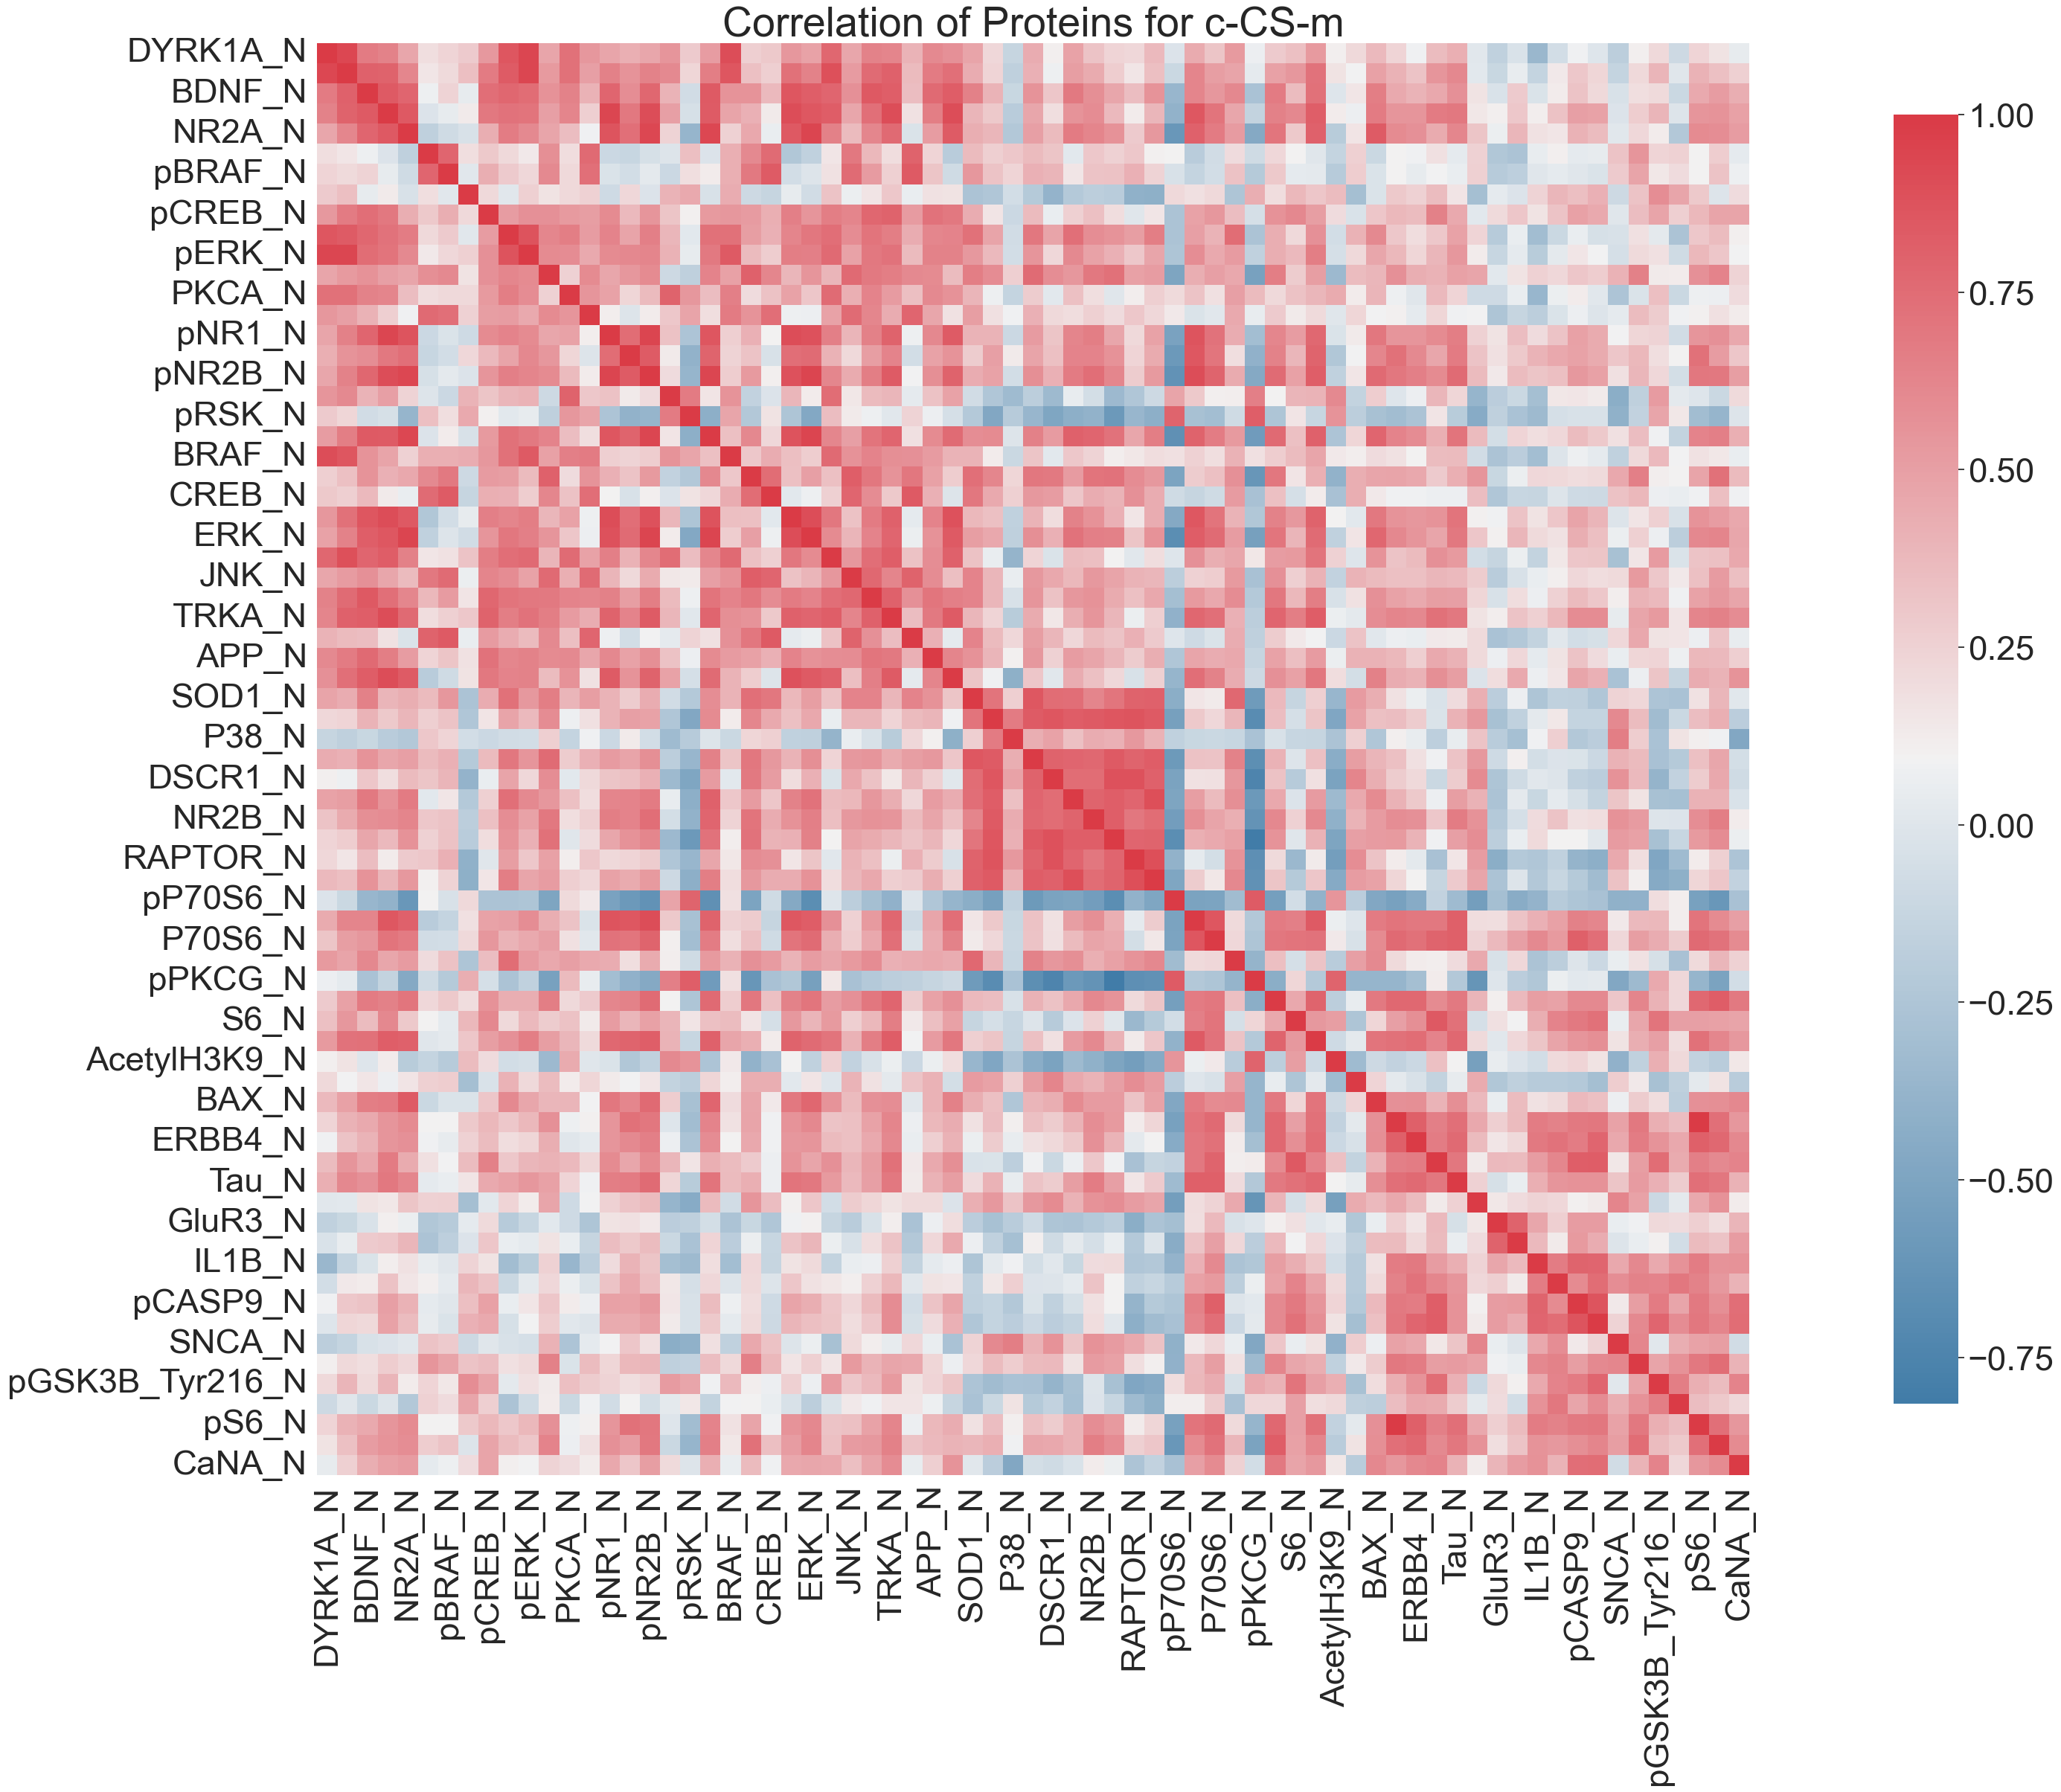

In [67]:
sns.set(font_scale = 3)
plot_corr(X_imp)
plt.title('Correlation of Proteins for c-CS-m', fontsize=40)
plt.show()


In [16]:
# Extract features from your dataset
X_imp_1 = features[1]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z_1, cluster_assignments_1 = hierarchical_clustering(X_imp_1, threshold)


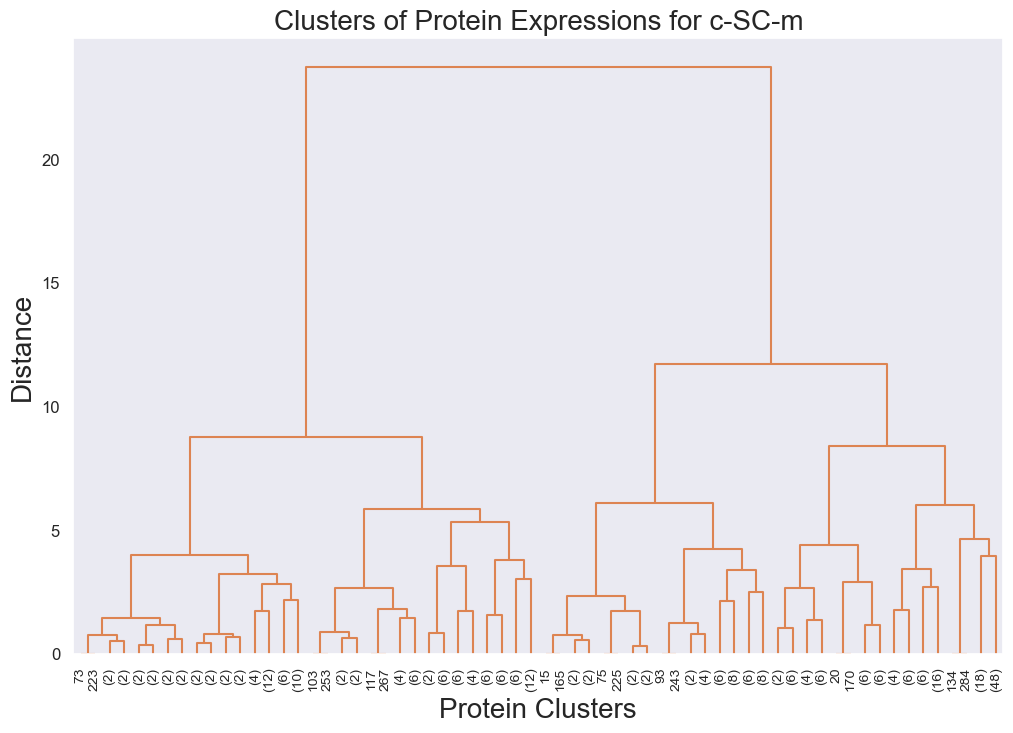

In [91]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z_1, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions for c-SC-m', fontsize = 20)
plt.xlabel('Protein Clusters', fontsize = 20)
plt.ylabel('Distance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.grid(False)
plt.show()


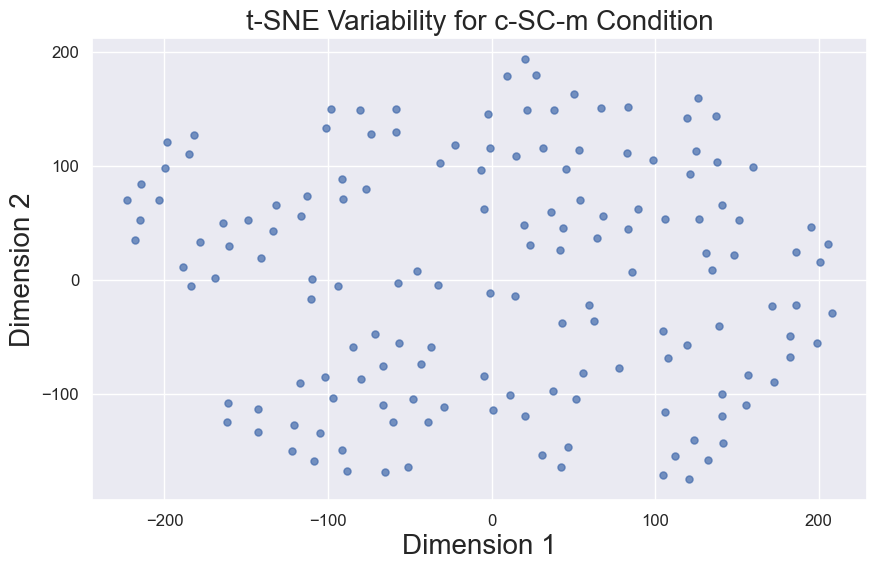

In [88]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings_1 = tsne.fit_transform(X_imp_1)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings_1[:, 0], tsne_embeddings_1[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Variability for c-SC-m Condition', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 20)
plt.ylabel('Dimension 2', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


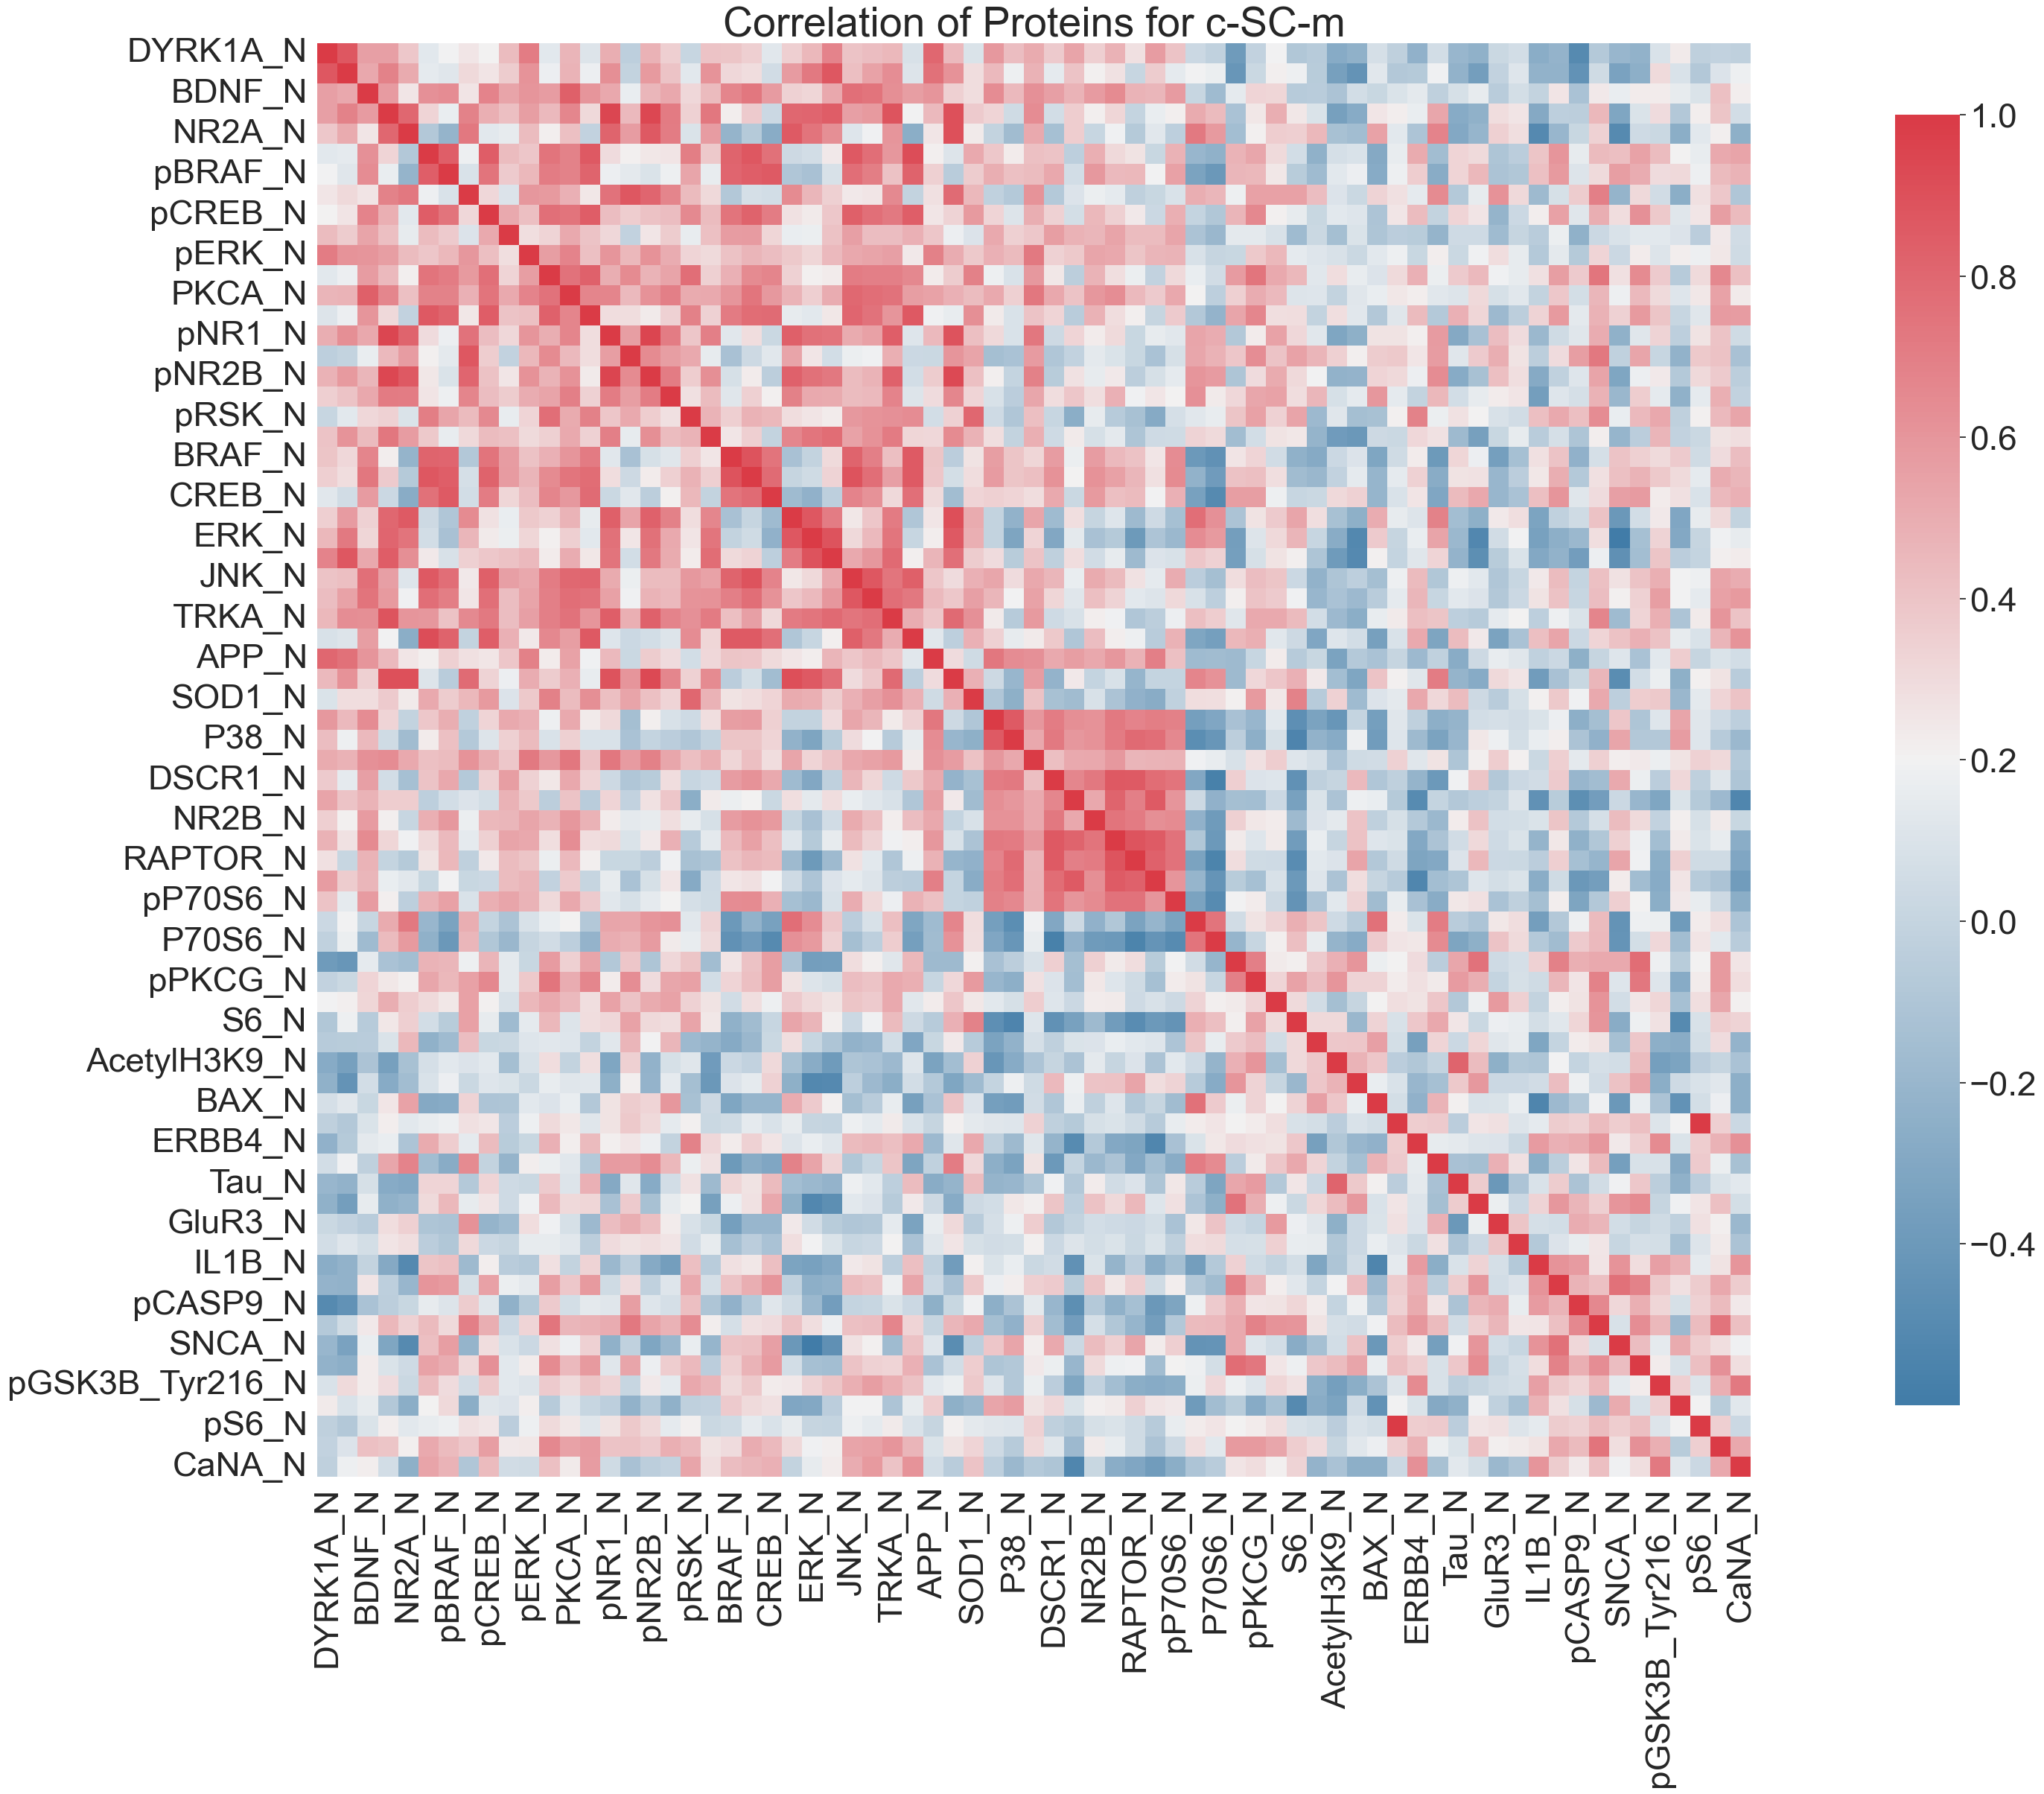

In [76]:
sns.set(font_scale = 3)   
plot_corr(X_imp_1)
plt.title('Correlation of Proteins for c-SC-m', fontsize=40)
plt.show()


In [20]:
# Extract features from your dataset
X_imp_2 = features[2]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z_2, cluster_assignments_2 = hierarchical_clustering(X_imp_2, threshold)


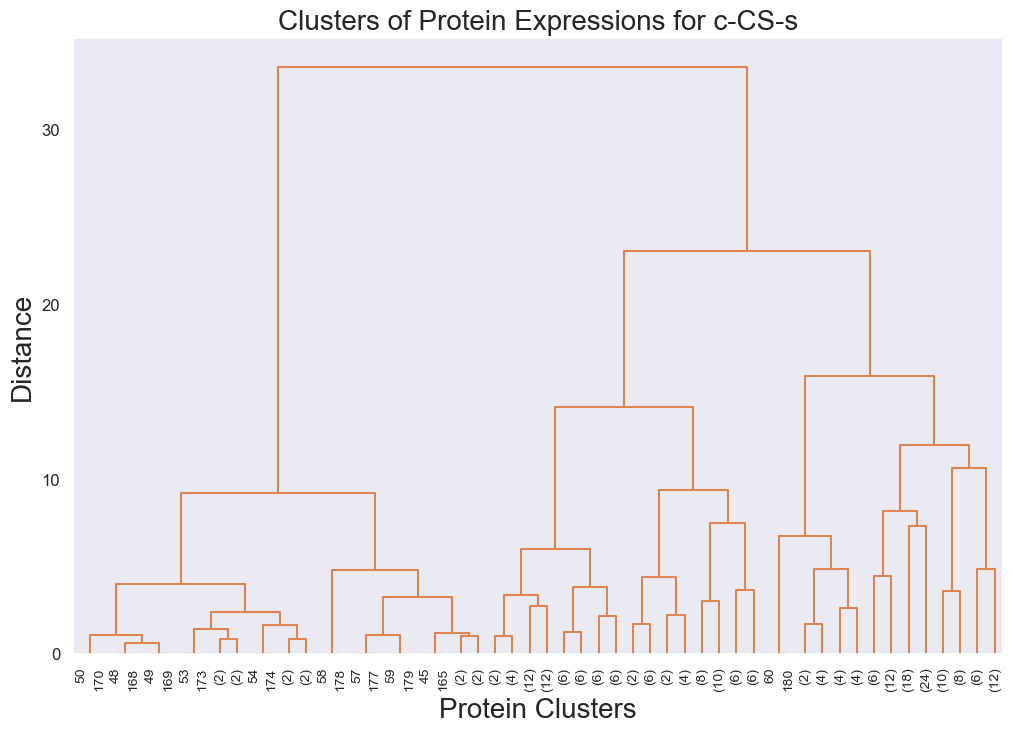

In [92]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z_2, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions for c-CS-s', fontsize = 20)
plt.xlabel('Protein Clusters', fontsize = 20)
plt.ylabel('Distance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.grid(False)
plt.show()


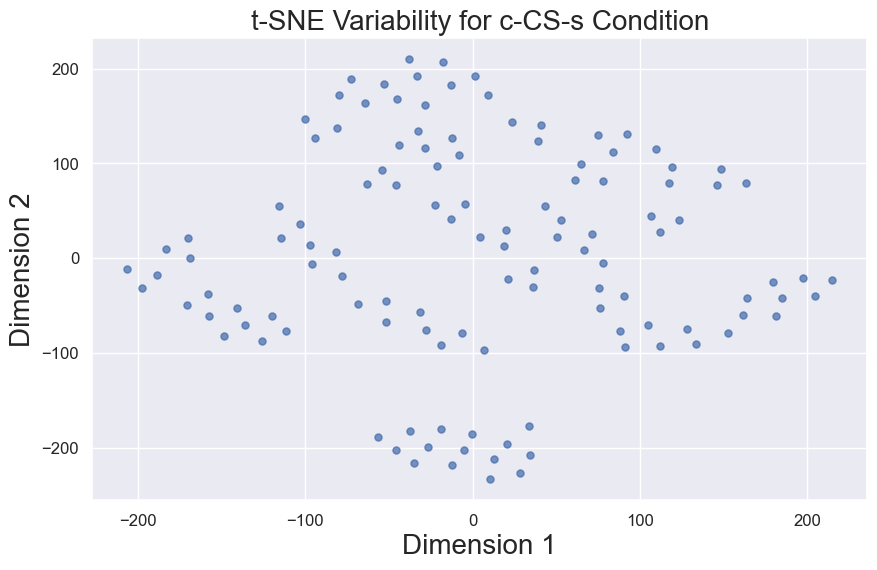

In [89]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components = 2, random_state = 42)
tsne_embeddings_2 = tsne.fit_transform(X_imp_2)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings_2[:, 0], tsne_embeddings_2[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Variability for c-CS-s Condition', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 20)
plt.ylabel('Dimension 2', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


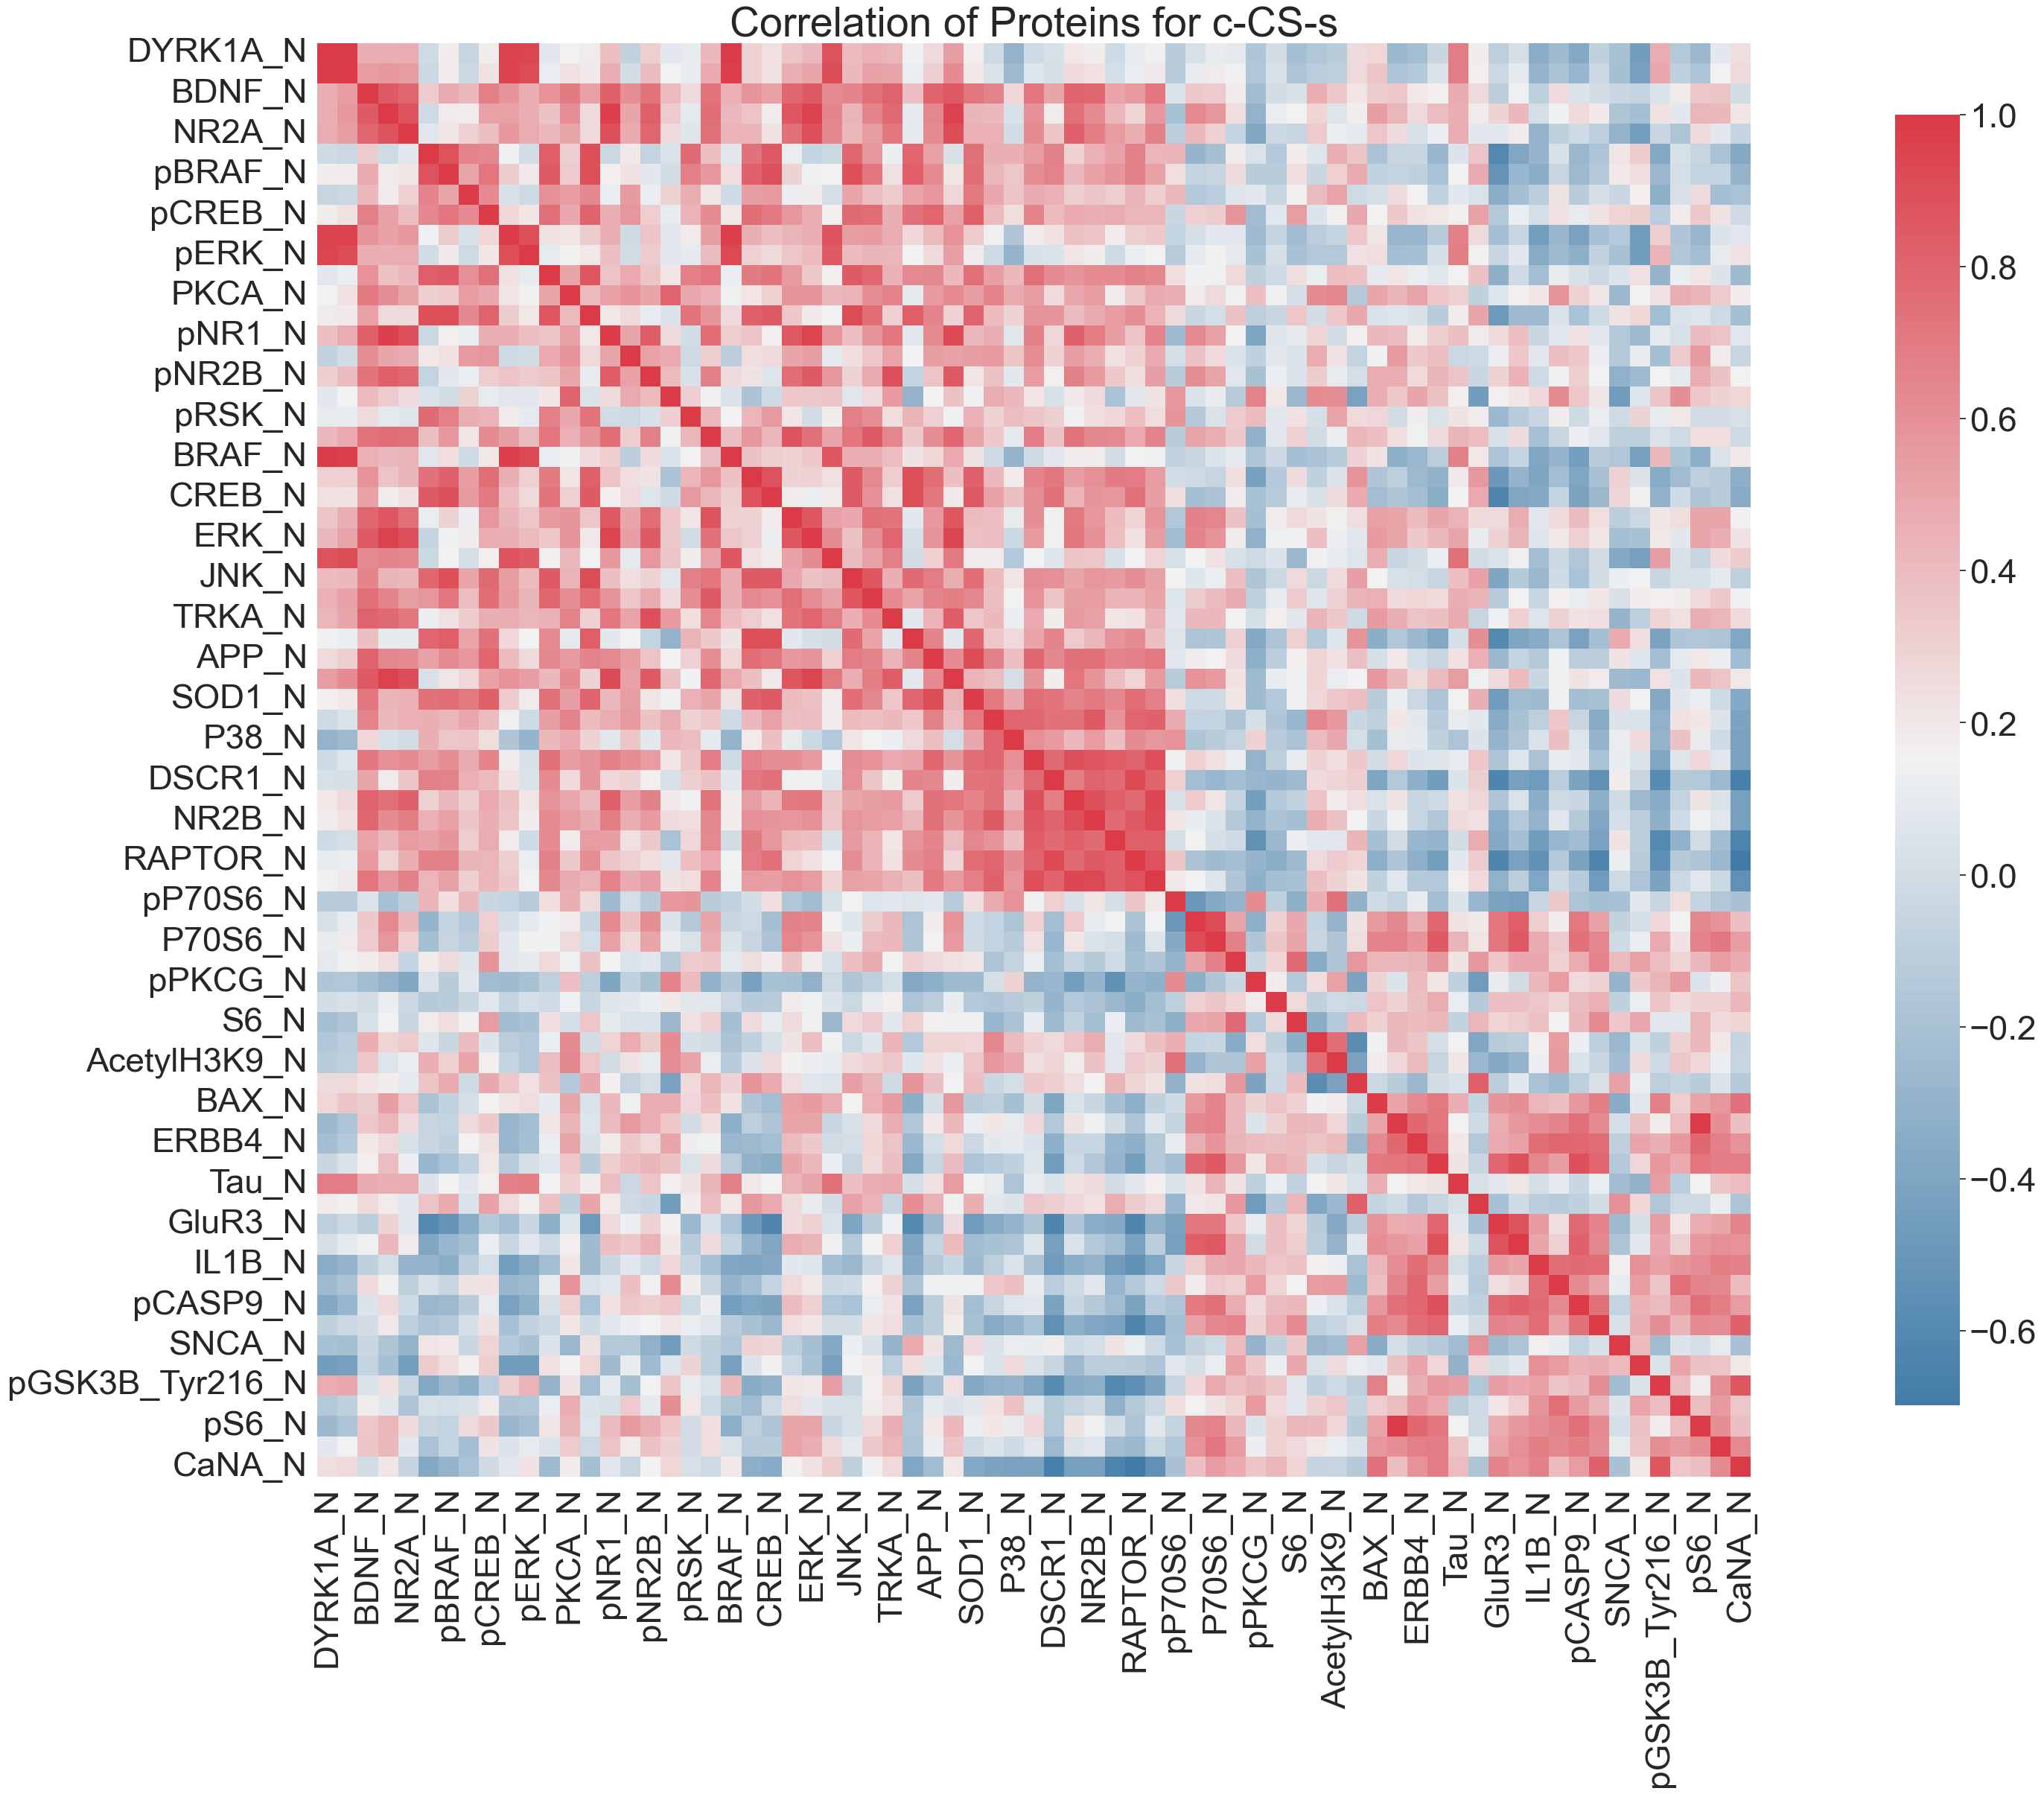

In [79]:
sns.set(font_scale = 3)   
plot_corr(X_imp_2)
plt.title('Correlation of Proteins for c-CS-s', fontsize=40)
plt.show()


In [24]:
# Extract features from your dataset
X_imp_3 = features[3]

# Define threshold for hierarchical clustering
threshold = 0.5

# Perform hierarchical clustering
Z_3, cluster_assignments_3 = hierarchical_clustering(X_imp_3, threshold)

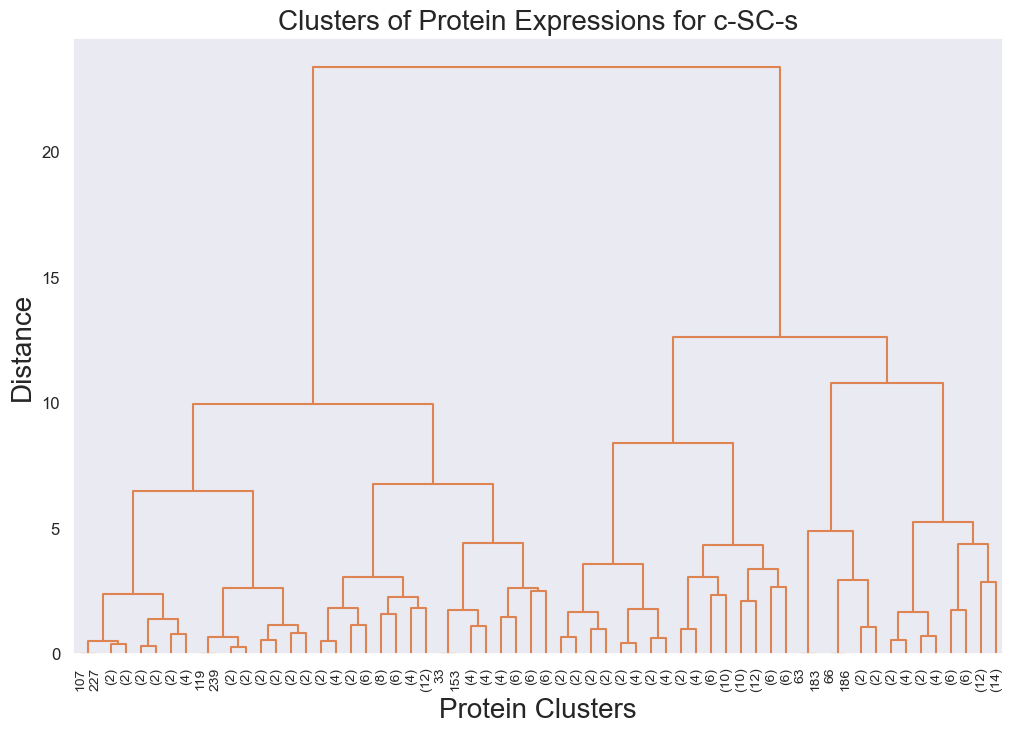

In [93]:
# Visualize the dendrogram with adjusted parameters
plt.figure(figsize=(12, 8))
dendrogram(Z_3, p = 5, truncate_mode = 'level', orientation='top', color_threshold=50, leaf_font_size=10)

plt.title('Clusters of Protein Expressions for c-SC-s', fontsize = 20)
plt.xlabel('Protein Clusters', fontsize = 20)
plt.ylabel('Distance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.grid(False)
plt.show()


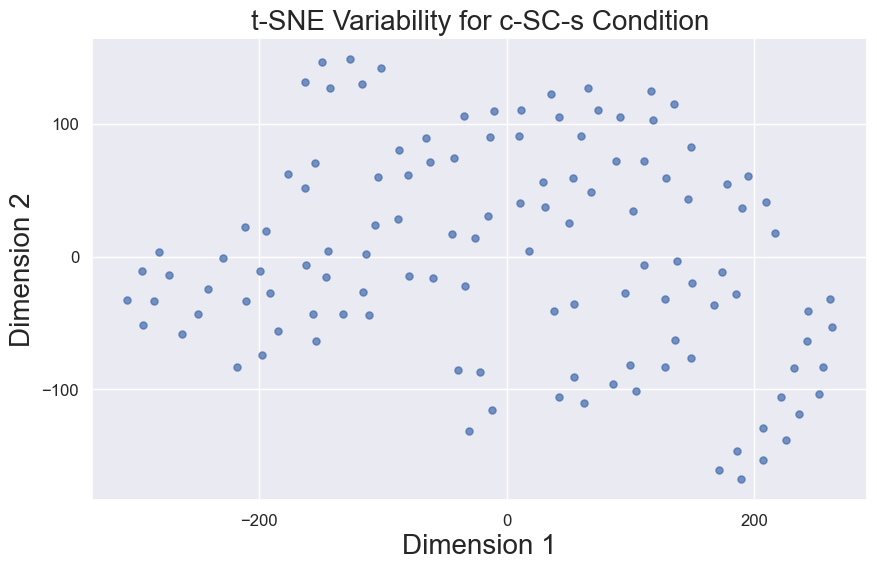

In [90]:
# Apply t-SNE to reduce the dimensionality to two dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings_3 = tsne.fit_transform(X_imp_3)

# Visualize the t-SNE embeddings
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings_3[:, 0], tsne_embeddings_3[:, 1], s=25, alpha=0.5)
plt.title('t-SNE Variability for c-SC-s Condition', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 20)
plt.ylabel('Dimension 2', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


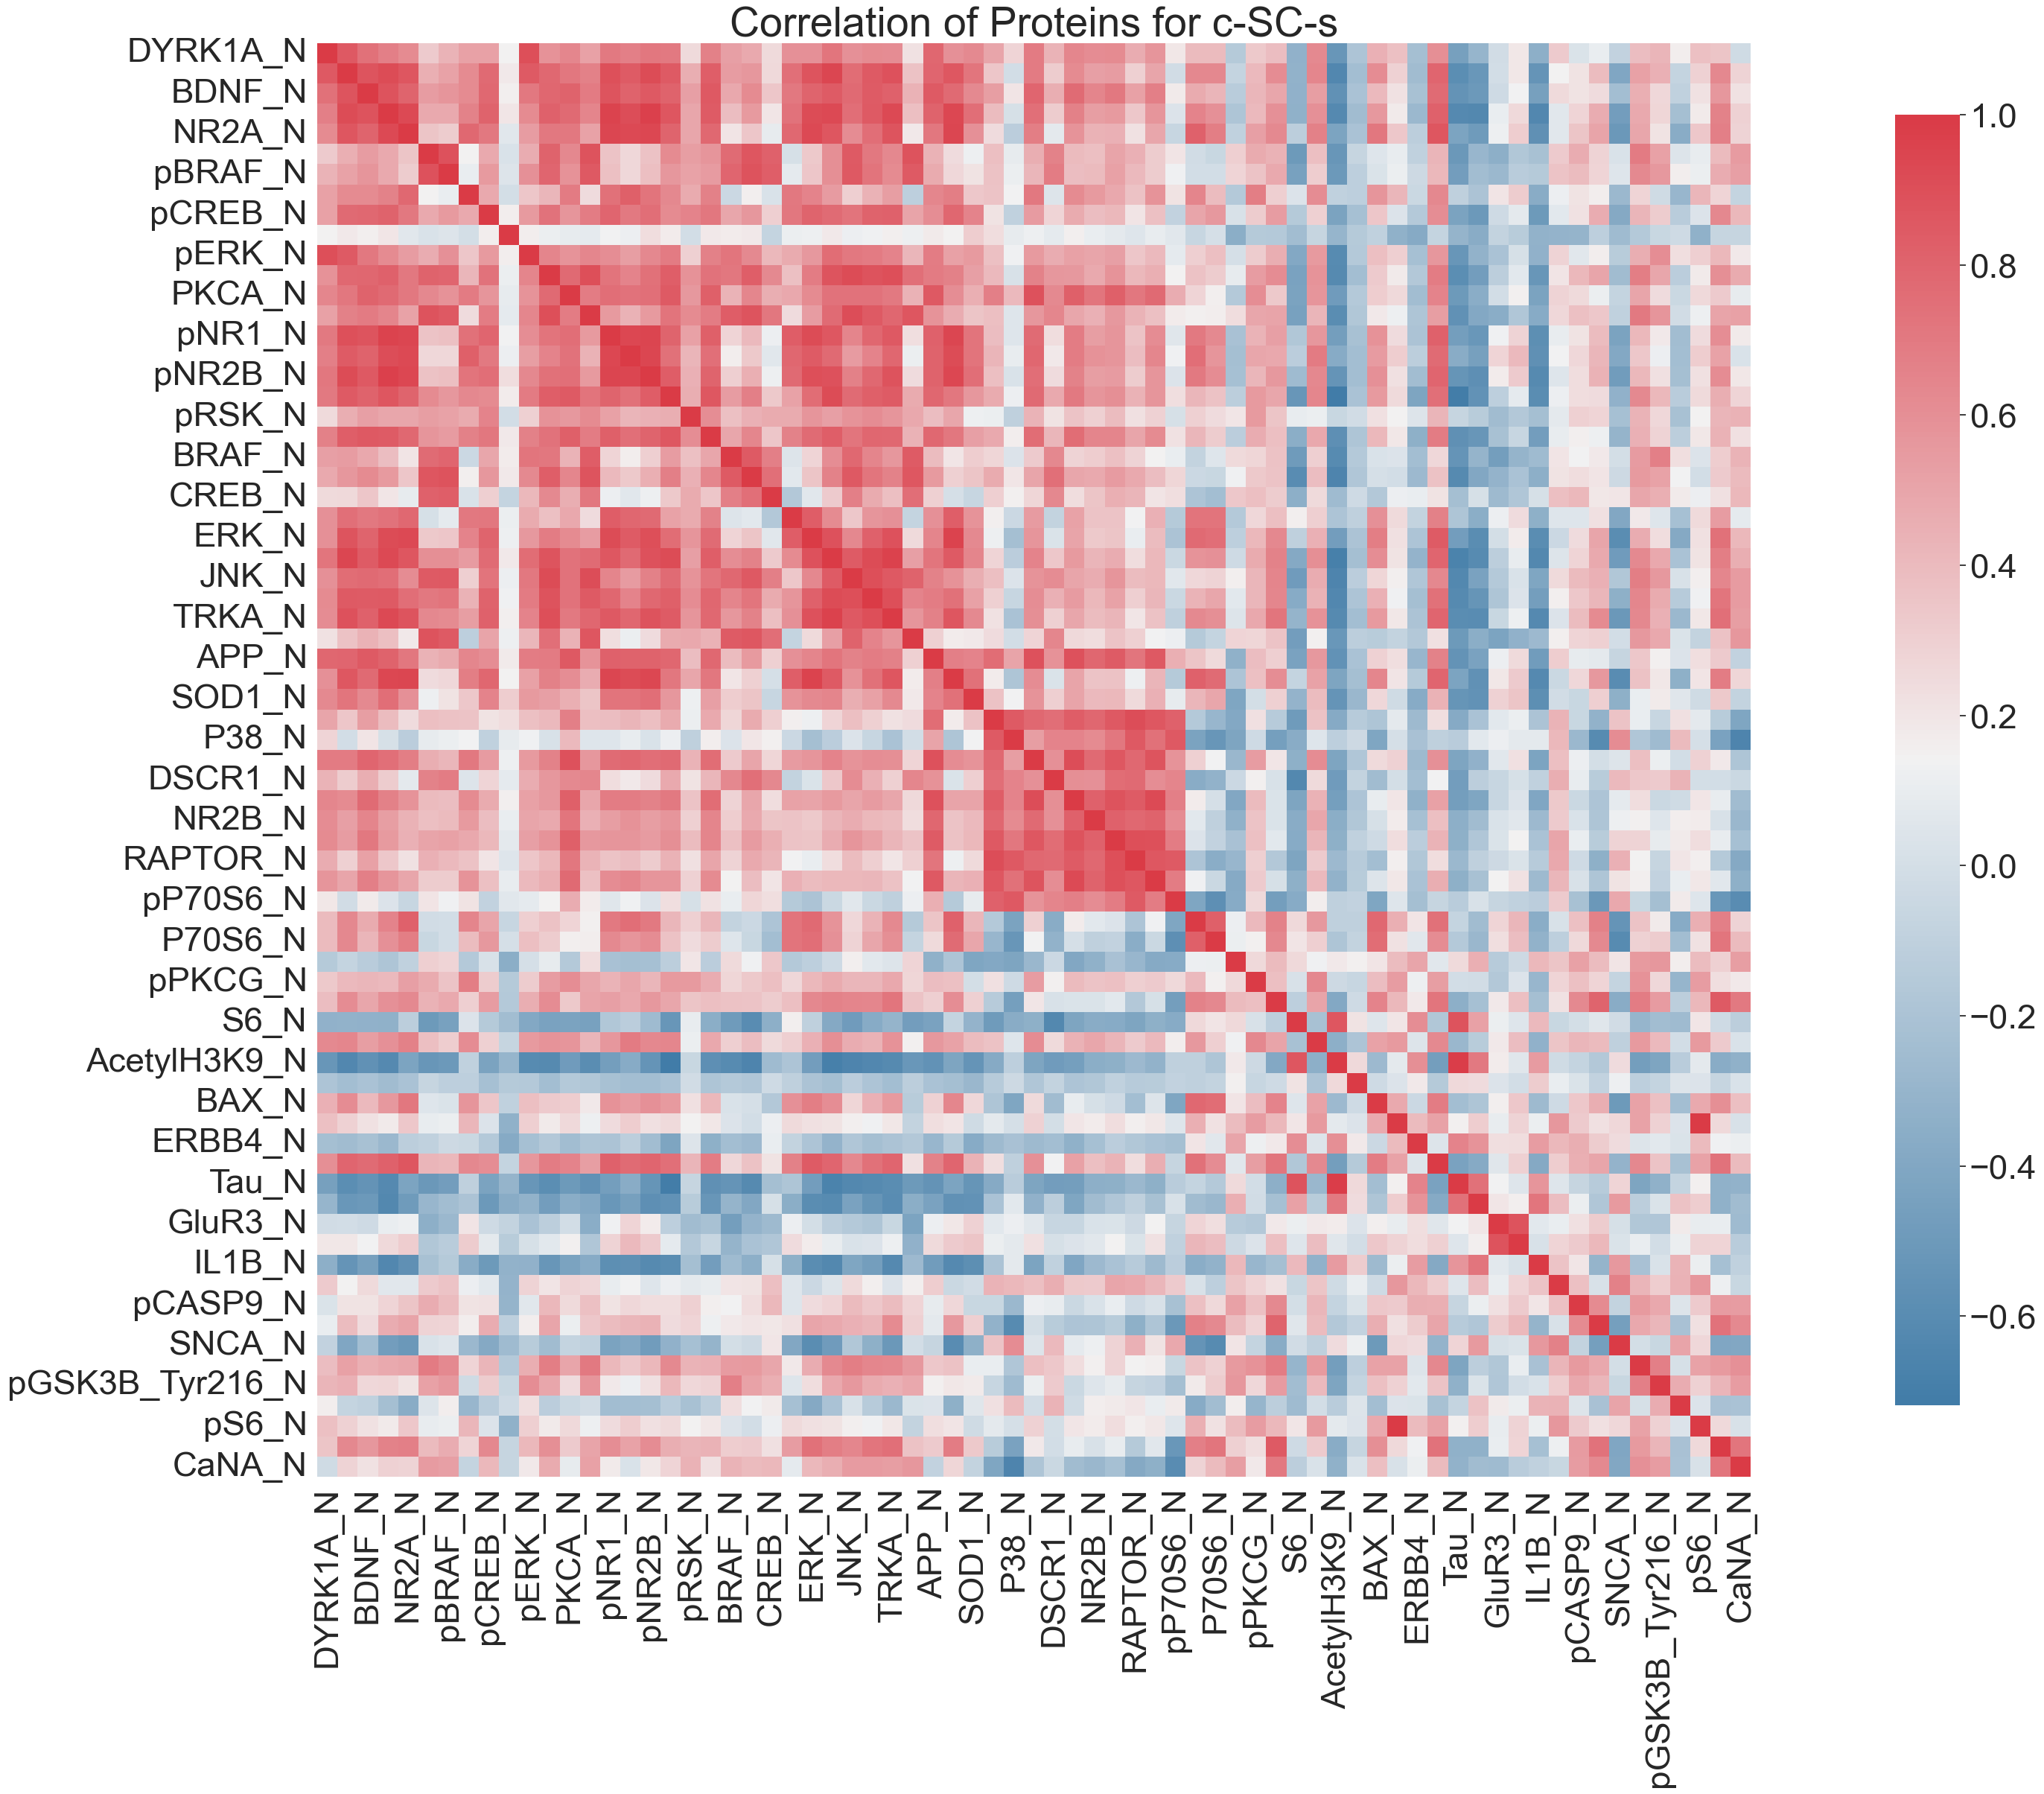

In [82]:
sns.set(font_scale = 3)   
plot_corr(X_imp_3)
plt.title('Correlation of Proteins for c-SC-s', fontsize=40)
plt.show()


## Finding ANOVA for each protein between each condition

In [28]:
# Looking at first 5 proteins being monitored
proteins = list(features[0].columns)
proteins[0:5]


['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N']

In [29]:
# Looking at expression levels of each mouse for brain-derived neurotrophic factor proteins
protein_BDNF = nmice['BDNF_N']
protein_BDNF.head()


0    0.430175
1    0.411770
2    0.418309
3    0.358626
4    0.358802
Name: BDNF_N, dtype: float64

In [30]:
conditions = nmice['class'].unique()
conditions


array(['c-CS-m', 'c-SC-m', 'c-CS-s', 'c-SC-s', 't-CS-m', 't-SC-m',
       't-CS-s', 't-SC-s'], dtype=object)

In [31]:
# # Finding the ANOVA of each condition for every protein expression

# for pro in proteins:
    
#     protein_data = nmice[[pro, 'class']]
#     groups = []
    
#     for condition in conditions:
#         groups.append(protein_data[protein_data['class'] == condition][pro])
    
#     f_statistic, p_value = f_oneway(*groups)
#     print("Protein:", pro)
#     print("F-statistic:", f_statistic)
#     print("p-value:", p_value)
    
#     if p_value < 0.05:
#         print("Null Hypothesis = FALSE")
#     else:
#         print("Null Hypothesis = TRUE") 
#     print('\n')


## Random Forest Classification

In [32]:
# Splitting the data into the target and features
X = nmice.loc[:, 'DYRK1A_N':'CaNA_N']
y = nmice['class']


In [33]:
# Splitting the train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)


In [34]:
#Creating a random forest classifier
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)

# Train the classifier
clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=1, random_state=42)

In [35]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.9952267303102625

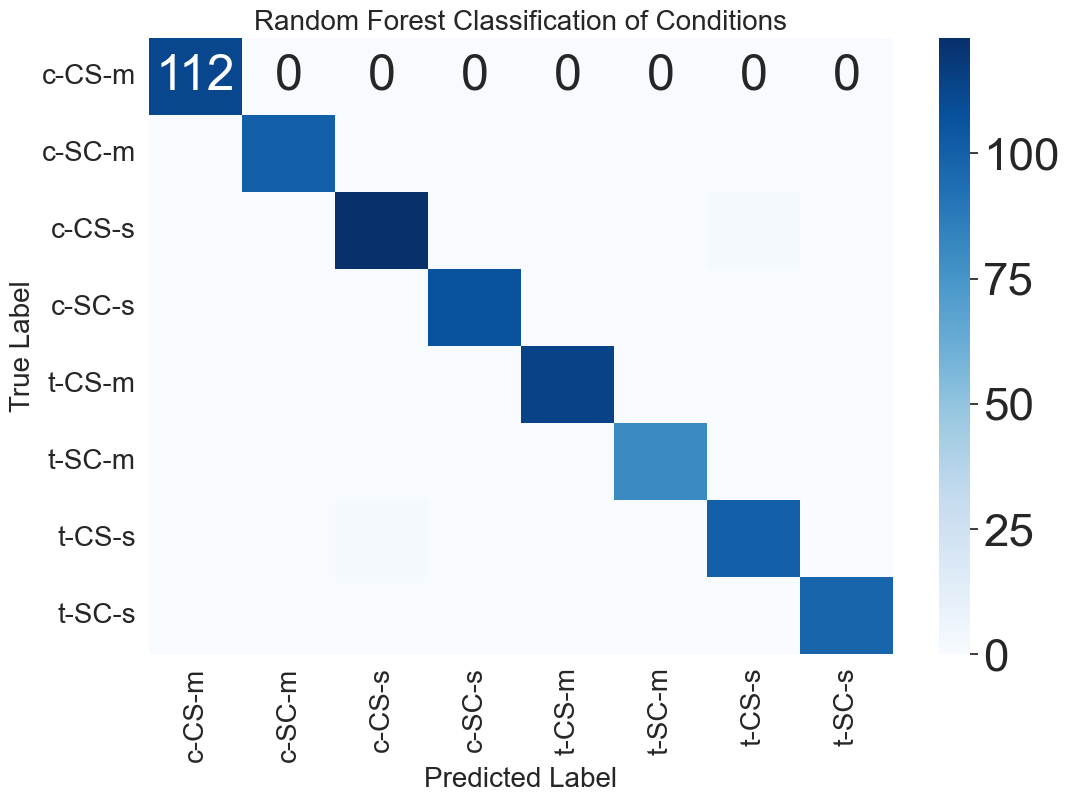

In [99]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=list(conditions), yticklabels=list(conditions))
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('True Label', fontsize = 20)
plt.title('Random Forest Classification of Conditions', size = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()


#### Finding important features from model

In [37]:
# assigning the all importance values to a series
importance = pd.Series(clf.feature_importances_)

# Print the name and gini importance of each feature
feat_list = []
for feature in zip(subset_cols, clf.feature_importances_):
    feat_list.append(feature)
    

In [38]:
sorted_feat_list = sorted(feat_list, key = lambda x: x[1], reverse = True)
sorted_feat_list[0:10]


[('SOD1_N', 0.06392723190057303),
 ('pPKCG_N', 0.03943927591563799),
 ('pERK_N', 0.03794169286137544),
 ('APP_N', 0.036590176267182126),
 ('CaNA_N', 0.03157035879557263),
 ('pP70S6_N', 0.03121194499433064),
 ('pCAMKII_N', 0.031040509666753802),
 ('pPKCAB_N', 0.02807107483101528),
 ('ITSN1_N', 0.027267539047615284),
 ('Ubiquitin_N', 0.02709389145613433)]

## Random Forest Model for Important Features

#### Create a selector object that will use the random forest classifier to identify features that have an importance of more than 0.02

In [39]:
sfm = SelectFromModel(clf, threshold=0.02)

# Train the selector
sfm.fit(X_train, y_train)

# making arrays to keep track of the important proteins' importance values and index
imp = []
imp_index = []

# Print the names of the most important features
for feature_idx in sfm.get_support(indices = True):
    imp.append(list(subset_cols)[feature_idx])
    imp_index.append(feature_idx)

# Making the list of important proteins so I can make a dataframe with it
s_imp = pd.Series(imp)

# Getting the importance values of only the important proteins
protein_importance = importance[imp_index]

# Making a dataframe of the proteins with their importance values
p = {'Important Proteins': imp, 'Importance Value': protein_importance}
df_importance = pd.DataFrame(p)


In [40]:
# sorting the proteins by importance and printing it
df_importance.sort_values('Importance Value', ascending = False, inplace = True)
print(df_importance)


   Important Proteins  Importance Value
32             SOD1_N          0.063927
46            pPKCG_N          0.039439
10             pERK_N          0.037942
30              APP_N          0.036590
70             CaNA_N          0.031570
42           pP70S6_N          0.031212
7           pCAMKII_N          0.031041
17           pPKCAB_N          0.028071
1             ITSN1_N          0.027268
65        Ubiquitin_N          0.027094
20             BRAF_N          0.025906
0            DYRK1A_N          0.024176
68              pS6_N          0.023340
48               S6_N          0.022448
50       AcetylH3K9_N          0.021369
53              ARC_N          0.020772


In [41]:
# creating new training sets
X_imp_train = sfm.transform(X_train)
X_imp_test = sfm.transform(X_test)


In [42]:
# creating a new random forest model classifier for the most important features
clf_imp = RandomForestClassifier(n_estimators = 100, random_state = 42)

# training the random forest classfier on the new limited feature data sets
clf_imp.fit(X_imp_train, y_train)


RandomForestClassifier(random_state=42)

In [43]:
# Test the classifer to get the accuracy
y_imp_pred = clf_imp.predict(X_imp_test)

# Getting the accuracy score of the limited classifier model
accuracy_score(y_test, y_imp_pred)


0.9928400954653938

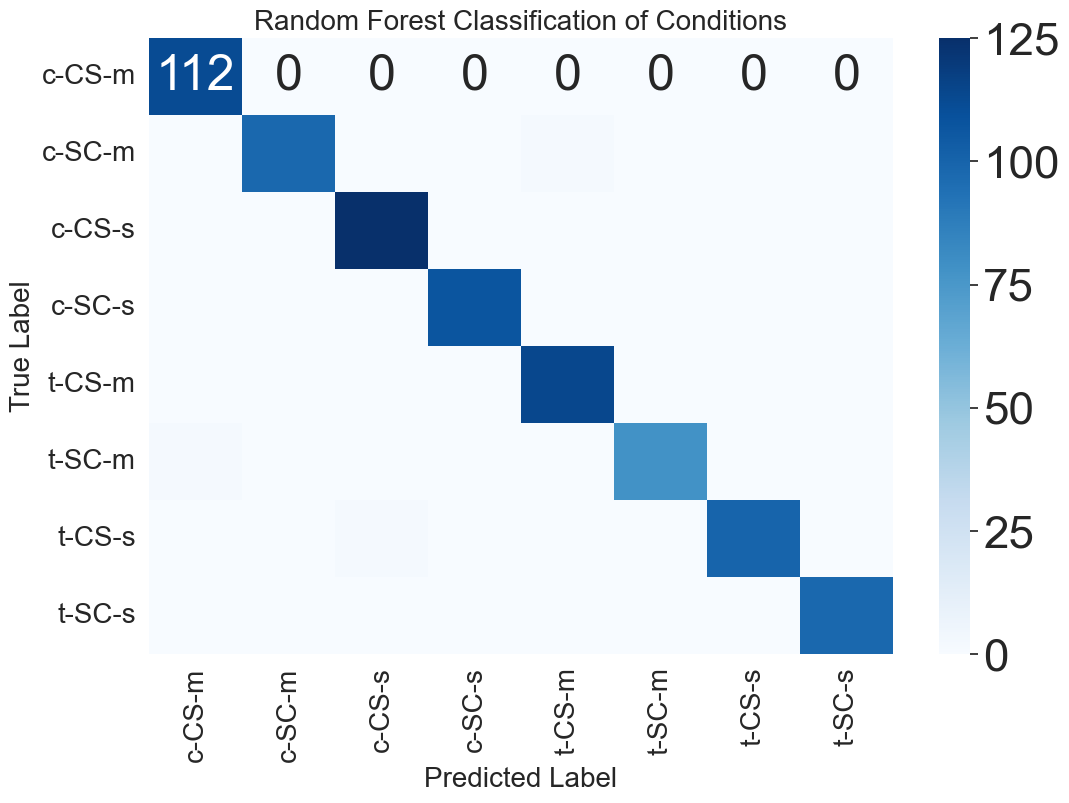

In [98]:
# Compute confusion matrix
cm_imp = confusion_matrix(y_test, y_imp_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm_imp, annot=True, cmap='Blues', fmt='d', xticklabels=list(conditions), yticklabels=list(conditions))
plt.xlabel('Predicted Label', fontsize = 20)
plt.ylabel('True Label', fontsize = 20)
plt.title('Random Forest Classification of Conditions', size = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()


## Exploring Important Proteins

In [45]:
# Creating a new dataset with only the important proteins
df_imp_proteins = nmice.loc[:, s_imp]
df_imp_proteins.head()


DYRK1A_N   ITSN1_N  pCAMKII_N    pERK_N  pPKCAB_N    BRAF_N     APP_N  \
0  0.503644  0.747193   2.373744  0.687906  2.308745  0.416289  0.453910   
1  0.514617  0.689064   2.292150  0.695006  2.043037  0.400364  0.430940   
2  0.509183  0.730247   2.283337  0.677348  2.017984  0.399847  0.423187   
3  0.442107  0.617076   2.152301  0.583277  2.132754  0.385639  0.410615   
4  0.434940  0.617430   2.134014  0.550960  2.013697  0.367531  0.398550   

     SOD1_N  pP70S6_N   pPKCG_N      S6_N  AcetylH3K9_N     ARC_N  \
0  0.369510  0.294170  1.443091  0.354605      0.170119  0.106305   
1  0.342279  0.276431  1.439460  0.354548      0.171427  0.106592   
2  0.343696  0.256648  1.524364  0.386087      0.185456  0.108303   
3  0.344509  0.398534  1.612382  0.290680      0.159799  0.103184   
4  0.329126  0.393447  1.645807  0.309345      0.164650  0.104784   

   Ubiquitin_N     pS6_N    CaNA_N  
0     1.044979  0.106305  1.675652  
1     1.009883  0.106592  1.743610  
2     0.996848  0.108303  1.926427  
3     0.990225  0.103184  1.700563  
4     0.997775  0.104784  1.839730

In [46]:
# imp_proteins = list(s_imp)

# for pro in imp_proteins:
    
#     protein_data = nmice[[pro, 'class']]
    
#     # Get unique combinations of conditions for pairwise comparisons
#     condition_pairs = combinations(conditions, 2)
    
#     for condition1, condition2 in condition_pairs:
#         group1 = protein_data[protein_data['class'] == condition1][pro]
#         group2 = protein_data[protein_data['class'] == condition2][pro]
        
#         # Perform t-test for the pair of groups
#         t_statistic, p_value = ttest_ind(group1, group2)
        
#         print("Protein:", pro)
#         print("Comparison:", condition1, "vs", condition2)
#         print("T-statistic:", t_statistic)
#         print("p-value:", p_value)
        
#         if p_value < 0.05:
#             print("Null Hypothesis = FALSE (There is a significant difference)")
#         else:
#             print("Null Hypothesis = TRUE (There is no significant difference)")
        
#         print('\n')
        

#### Visualizing the spread of important proteins on violin plots

/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


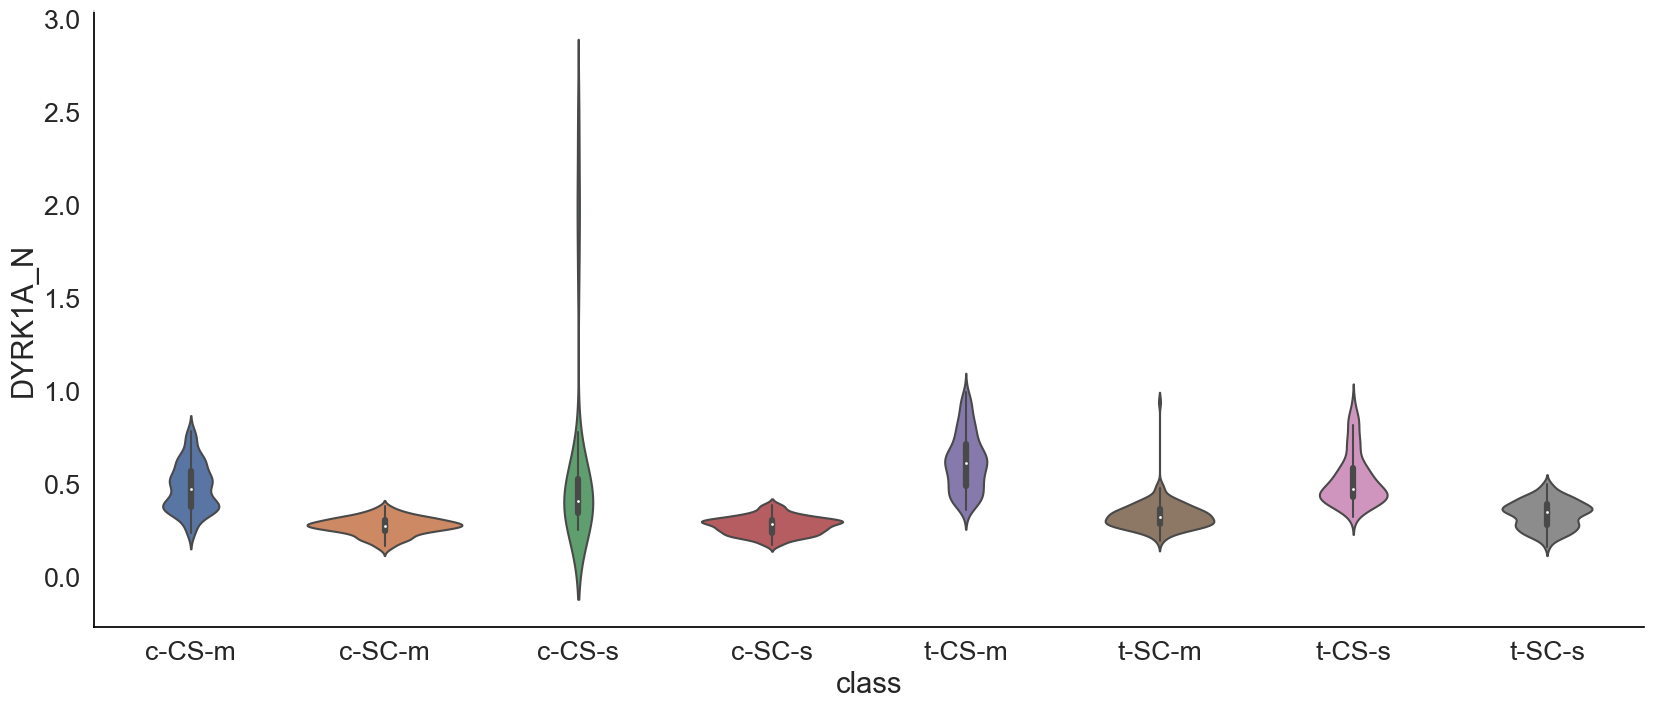

In [47]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='DYRK1A_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


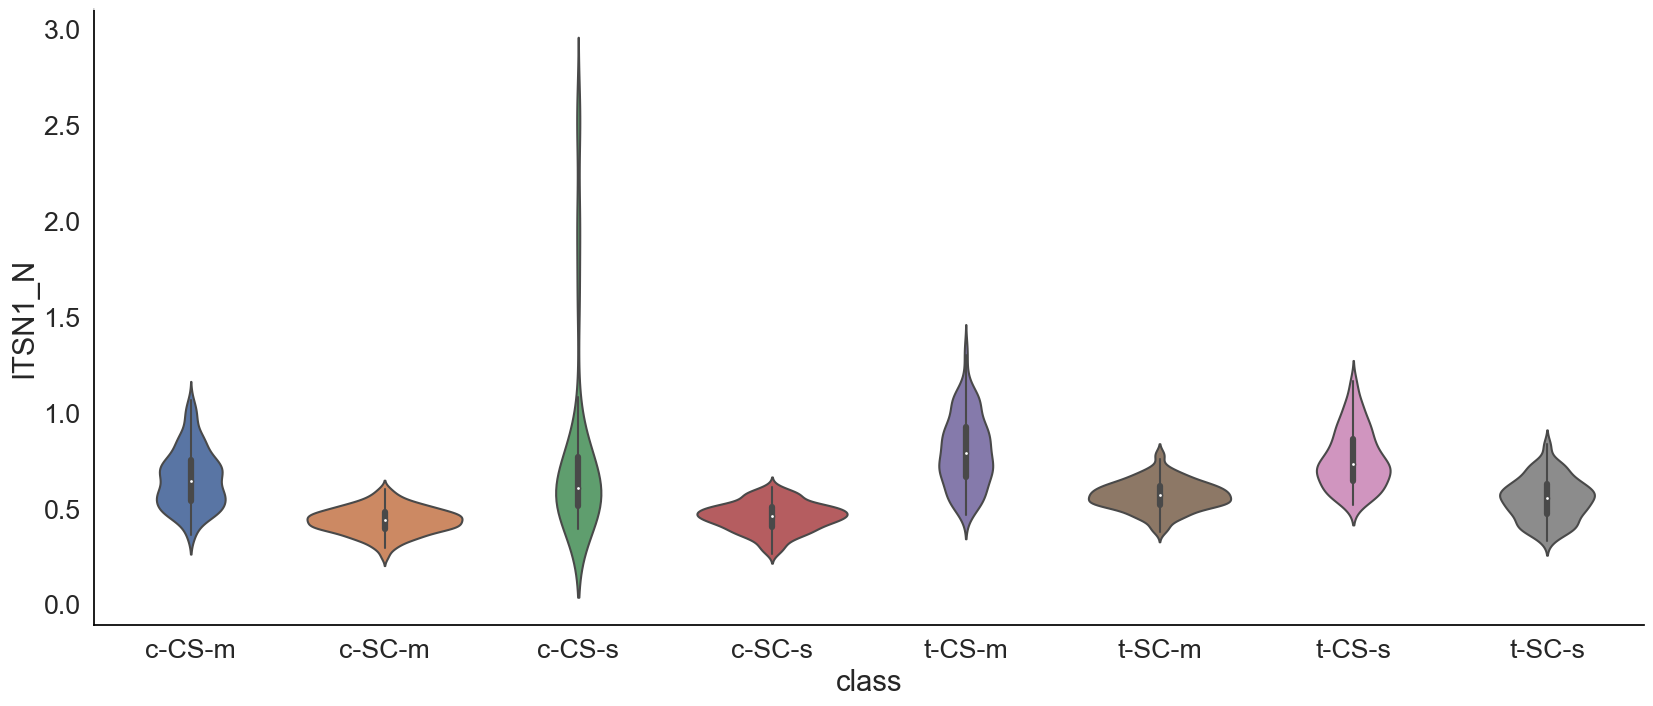

In [48]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='ITSN1_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


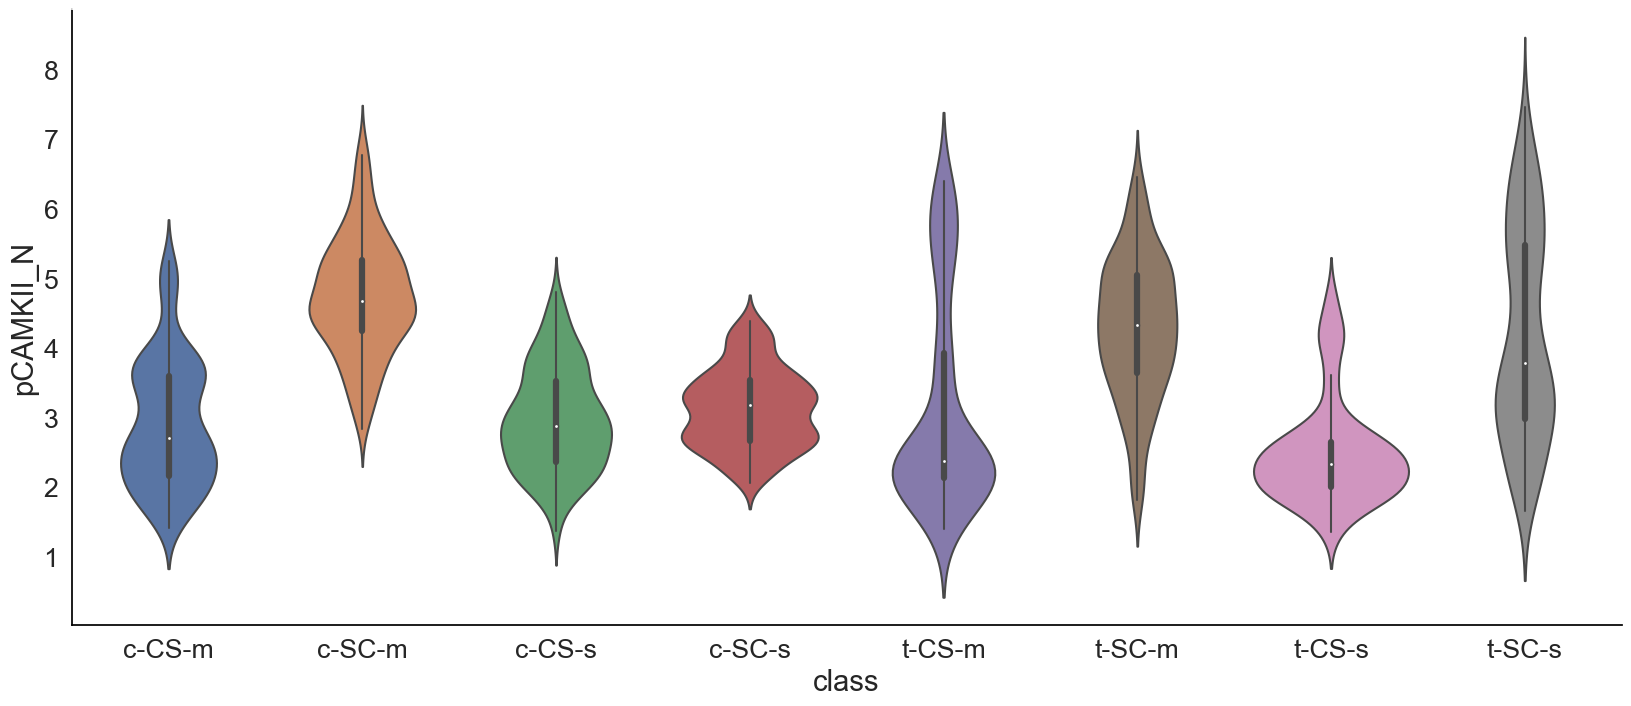

In [49]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='pCAMKII_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


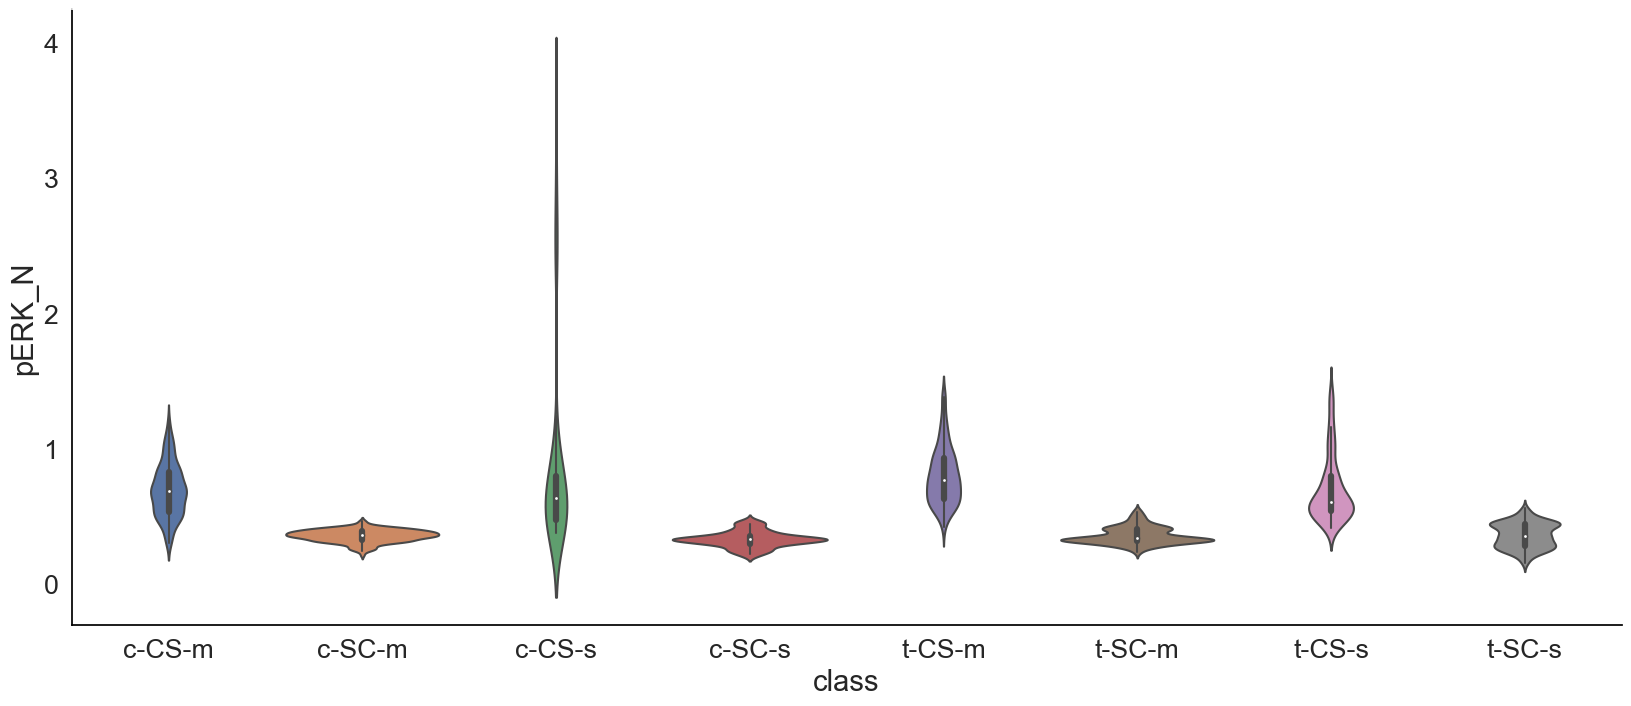

In [50]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='pERK_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


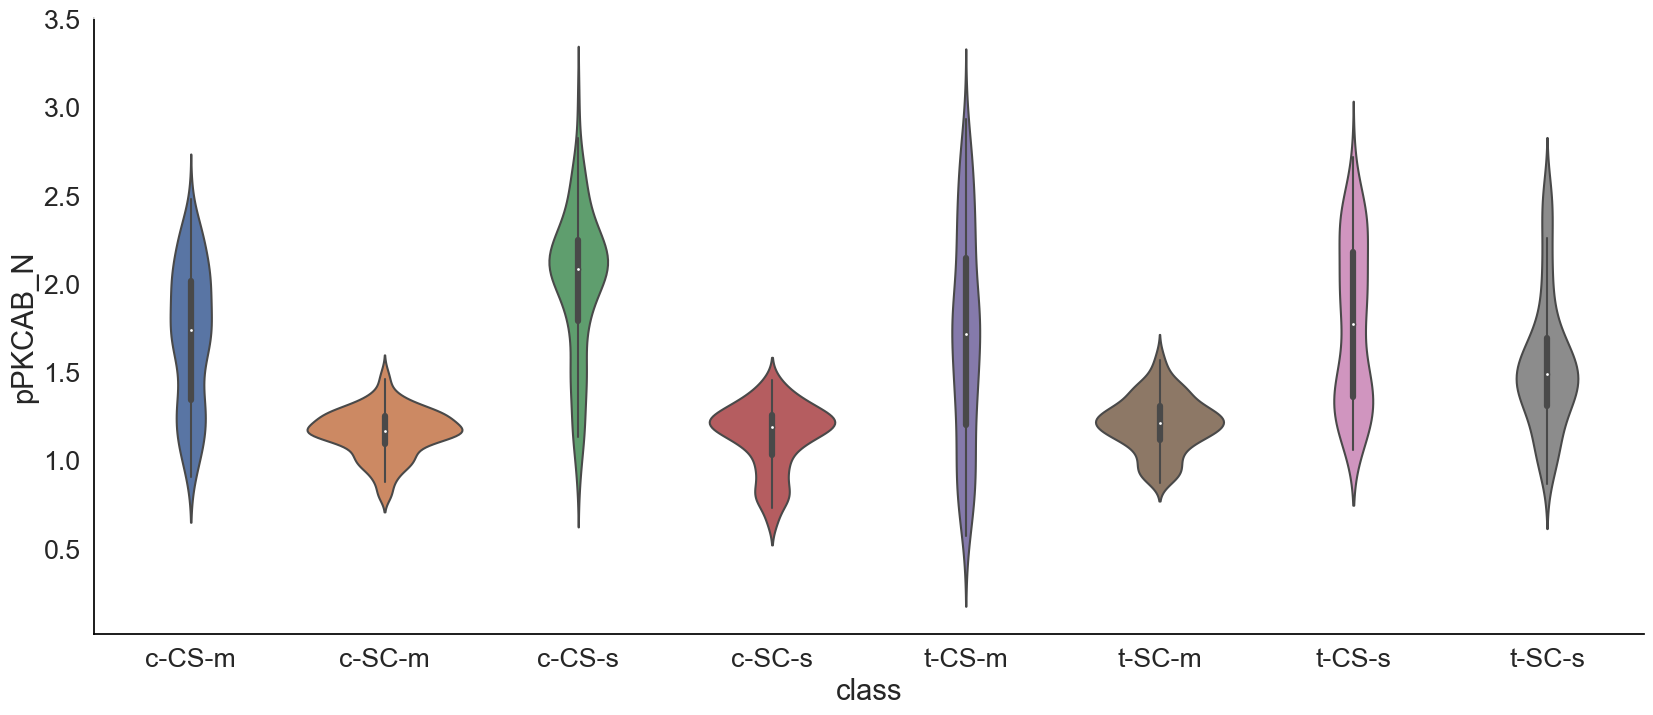

In [51]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='pPKCAB_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


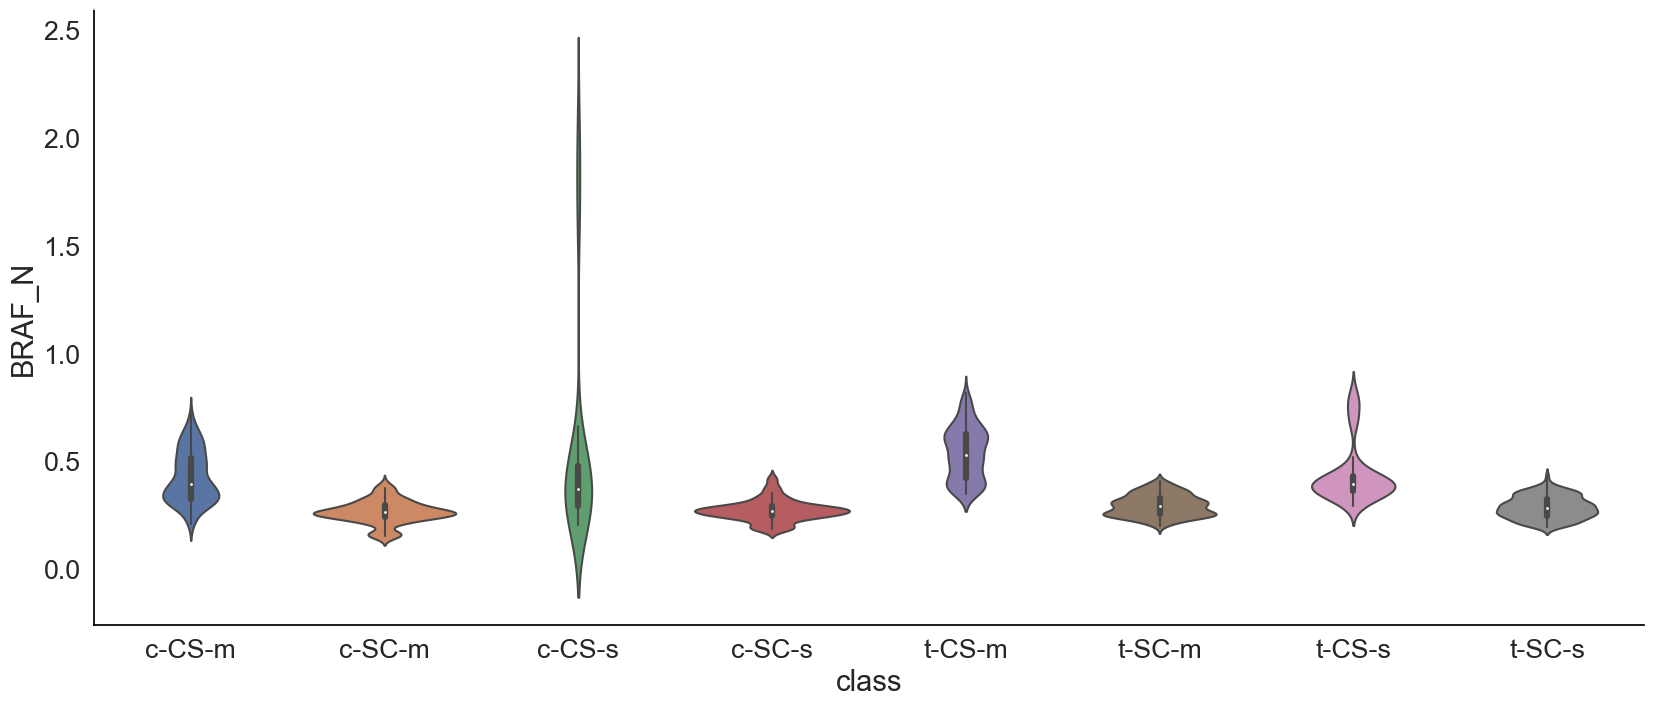

In [52]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='BRAF_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


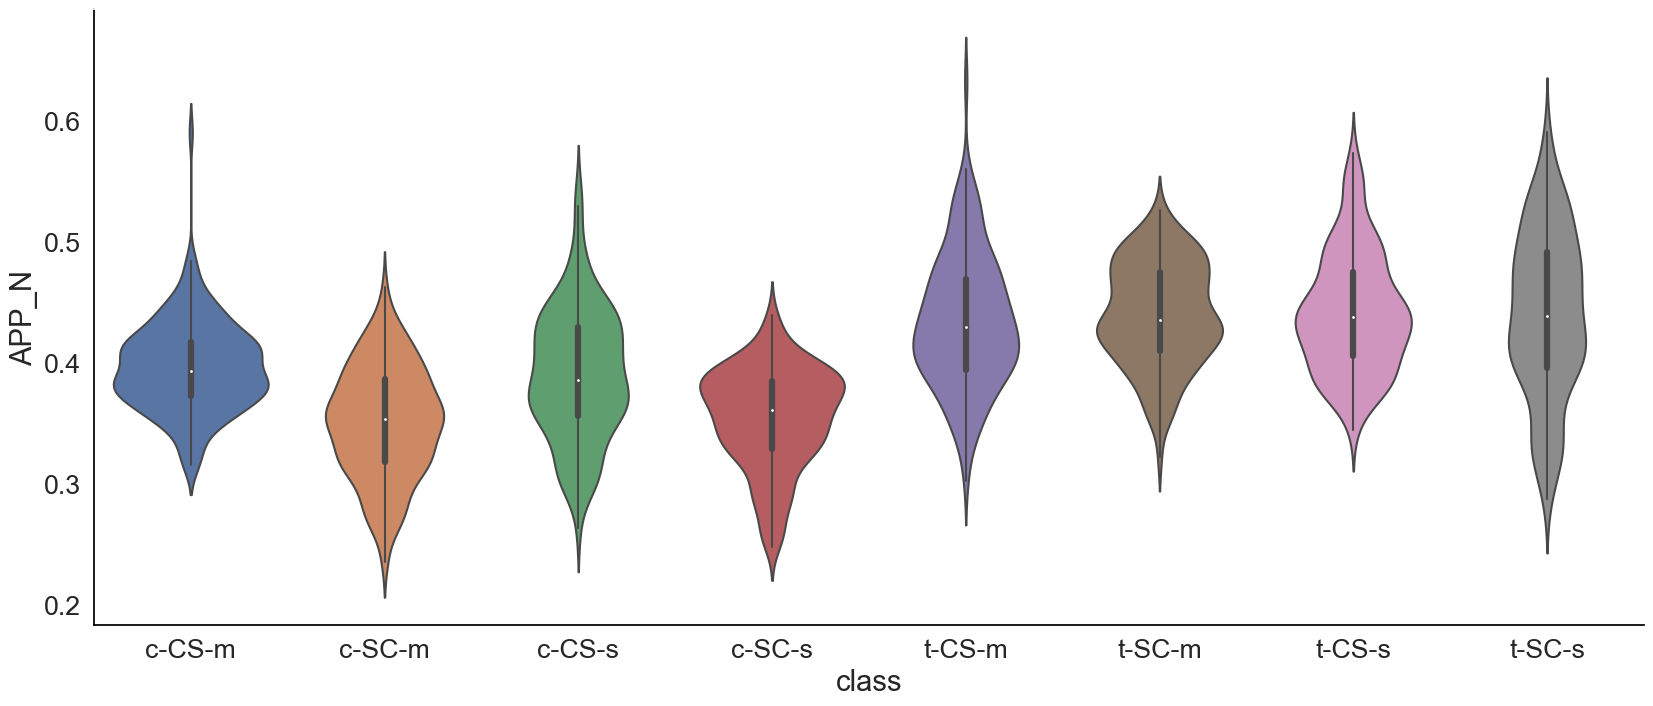

In [53]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='APP_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


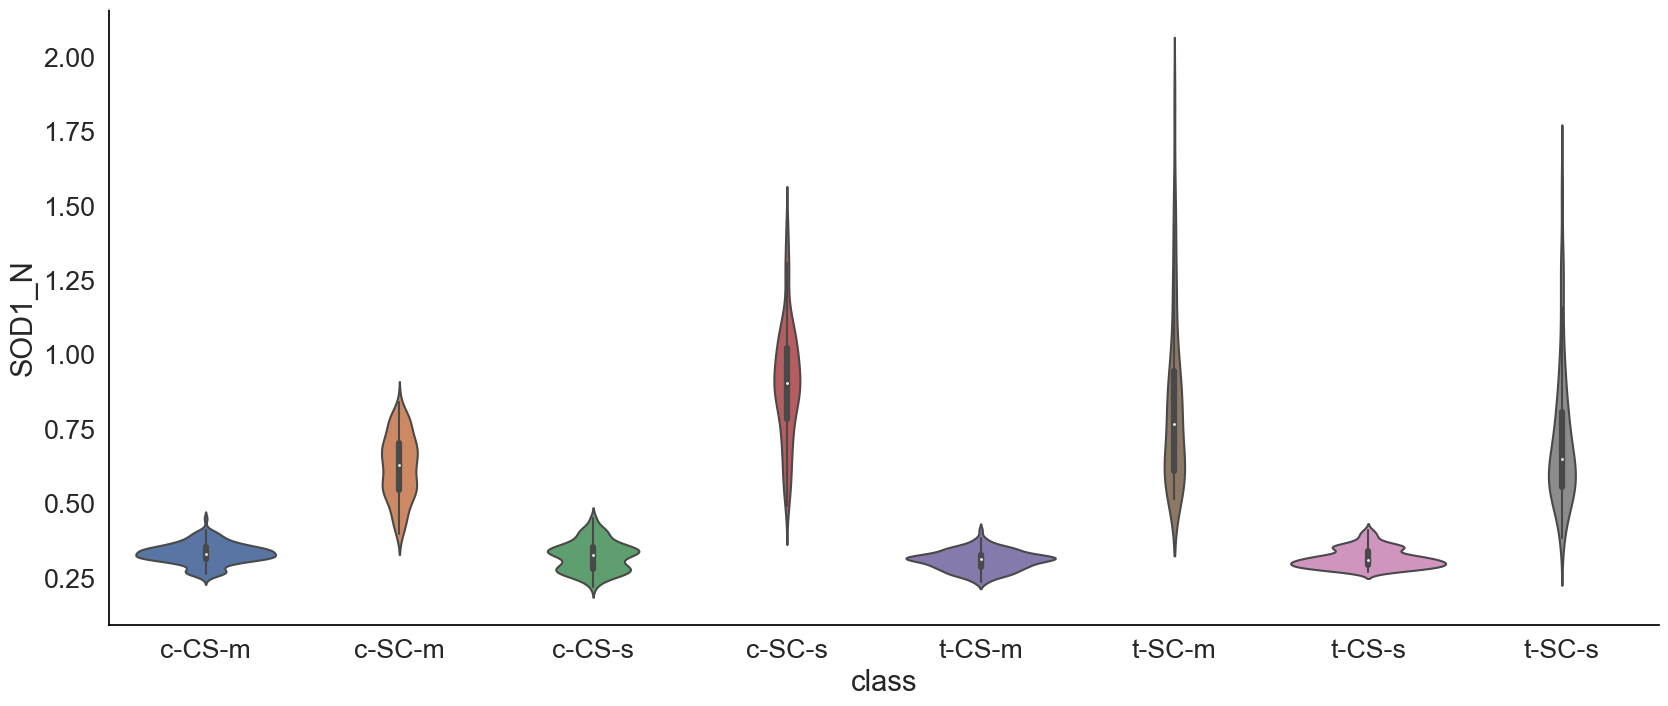

In [54]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='SOD1_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


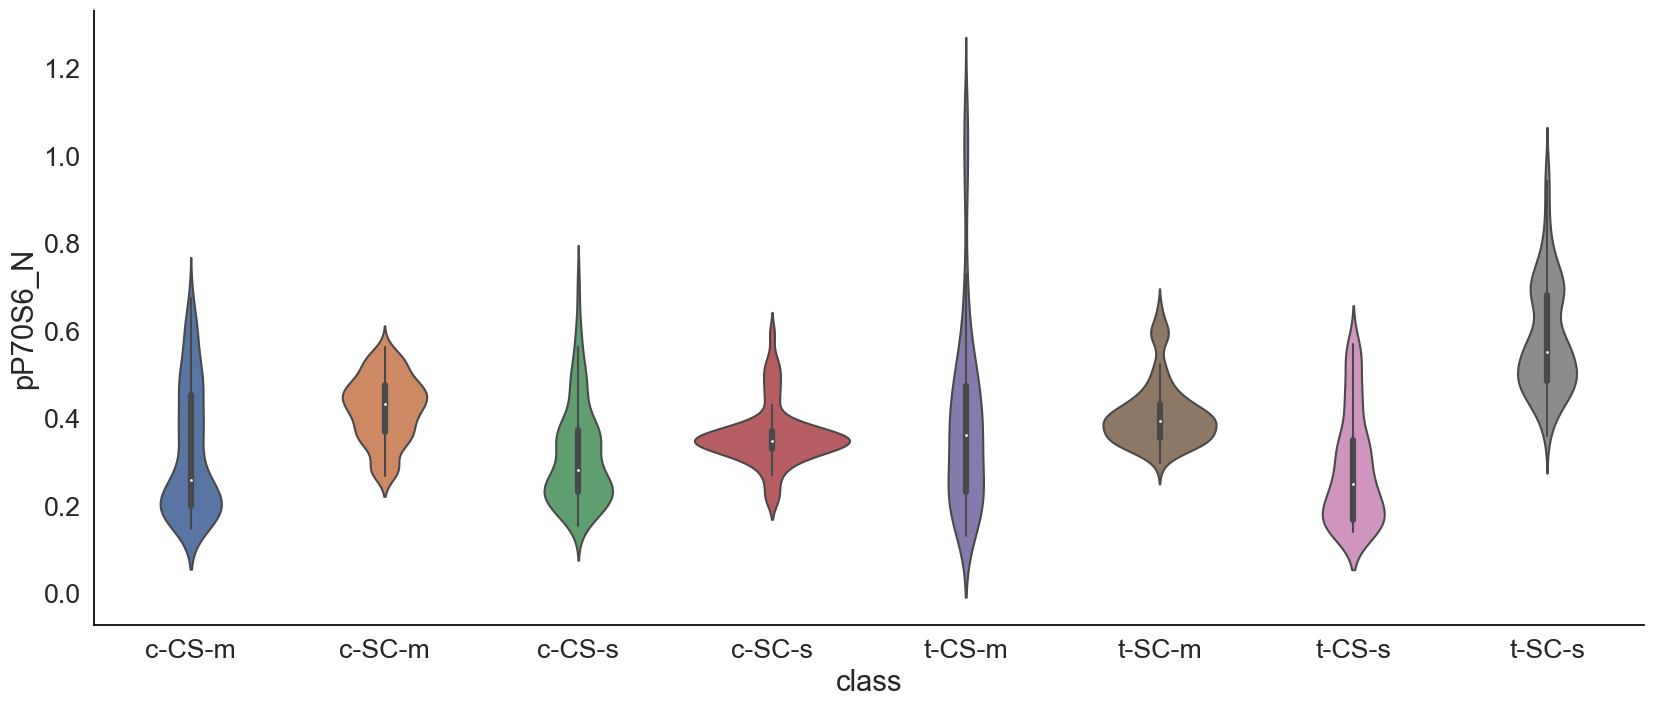

In [55]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='pP70S6_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


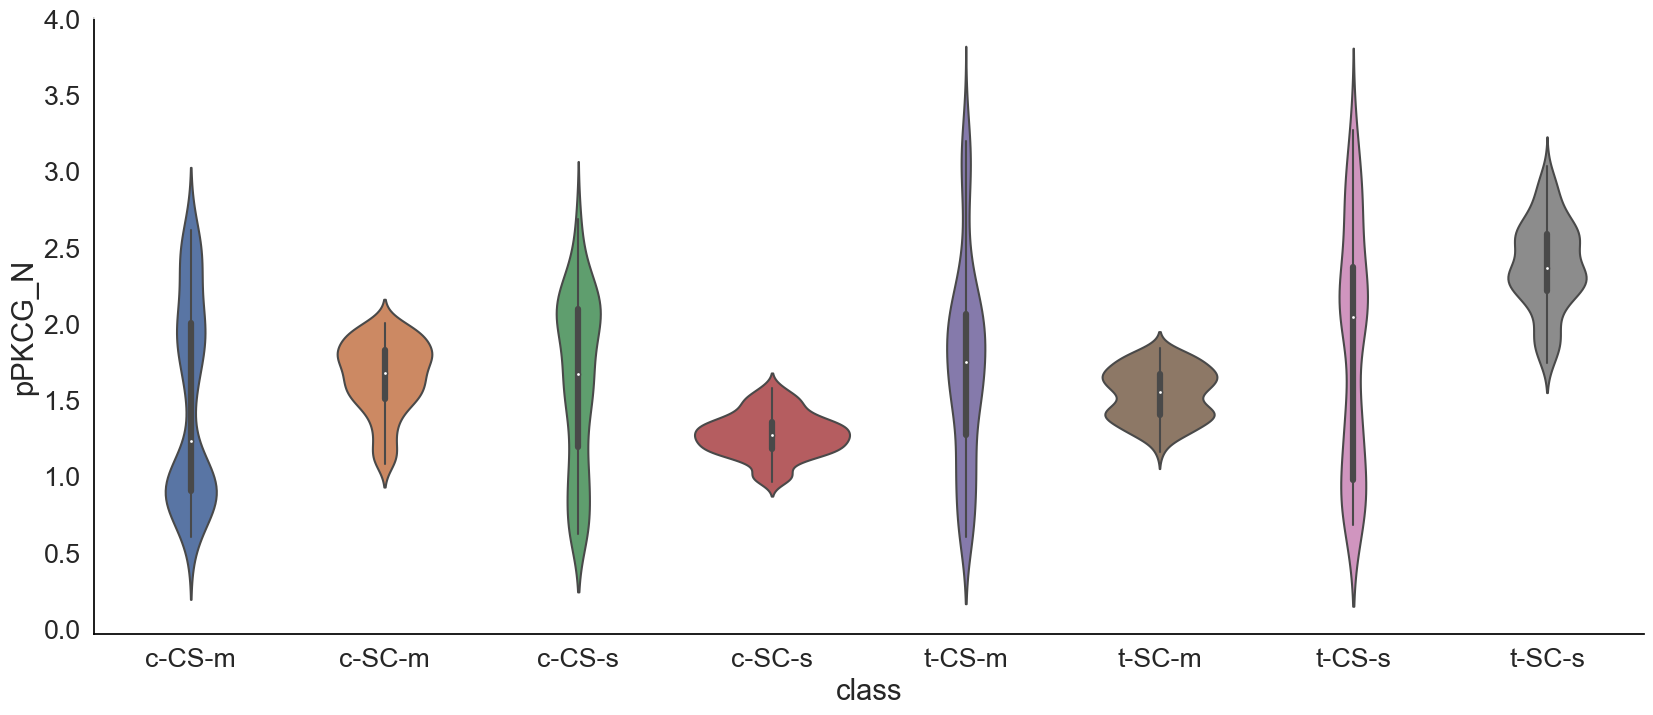

In [56]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='pPKCG_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


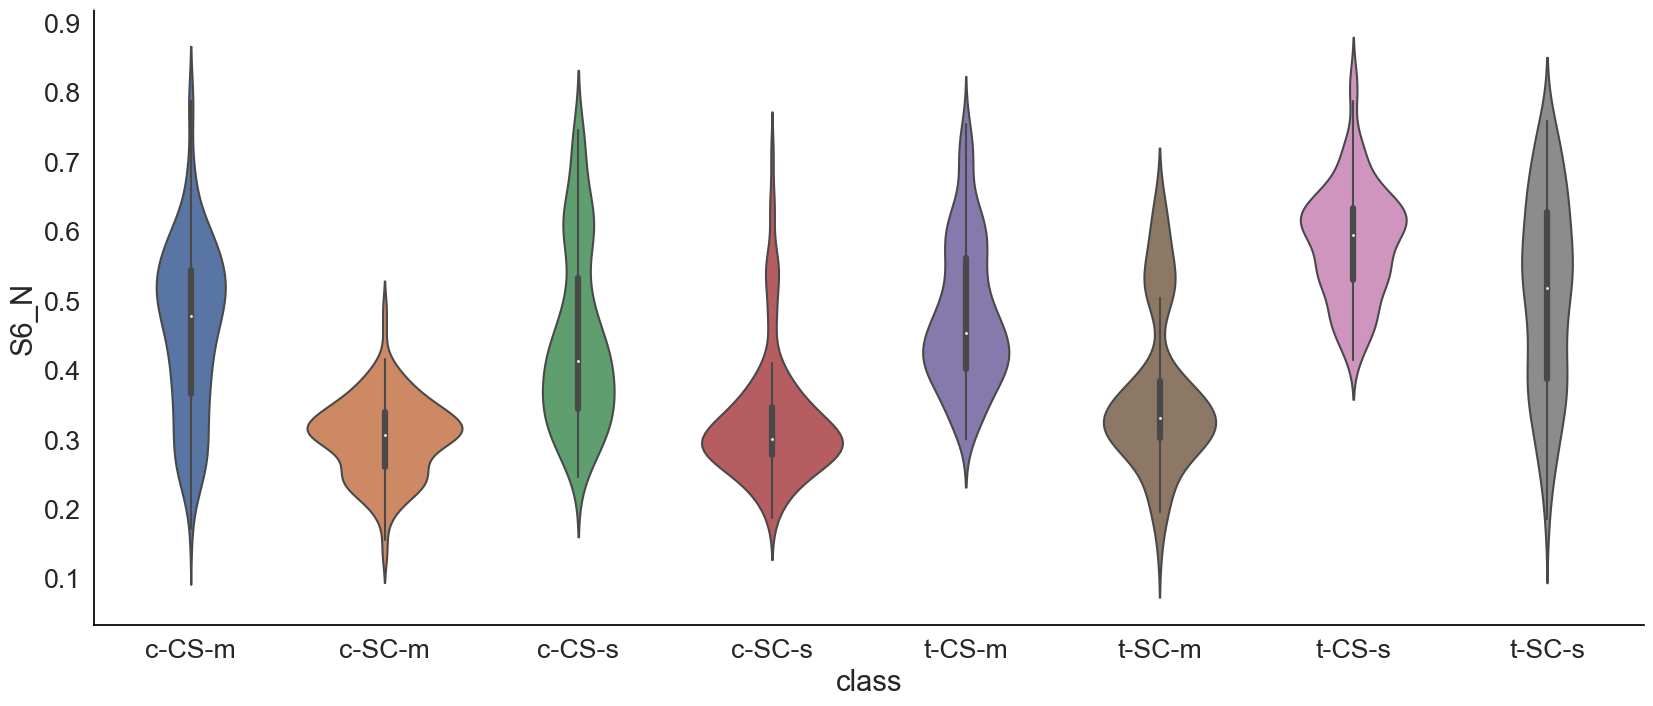

In [57]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='S6_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


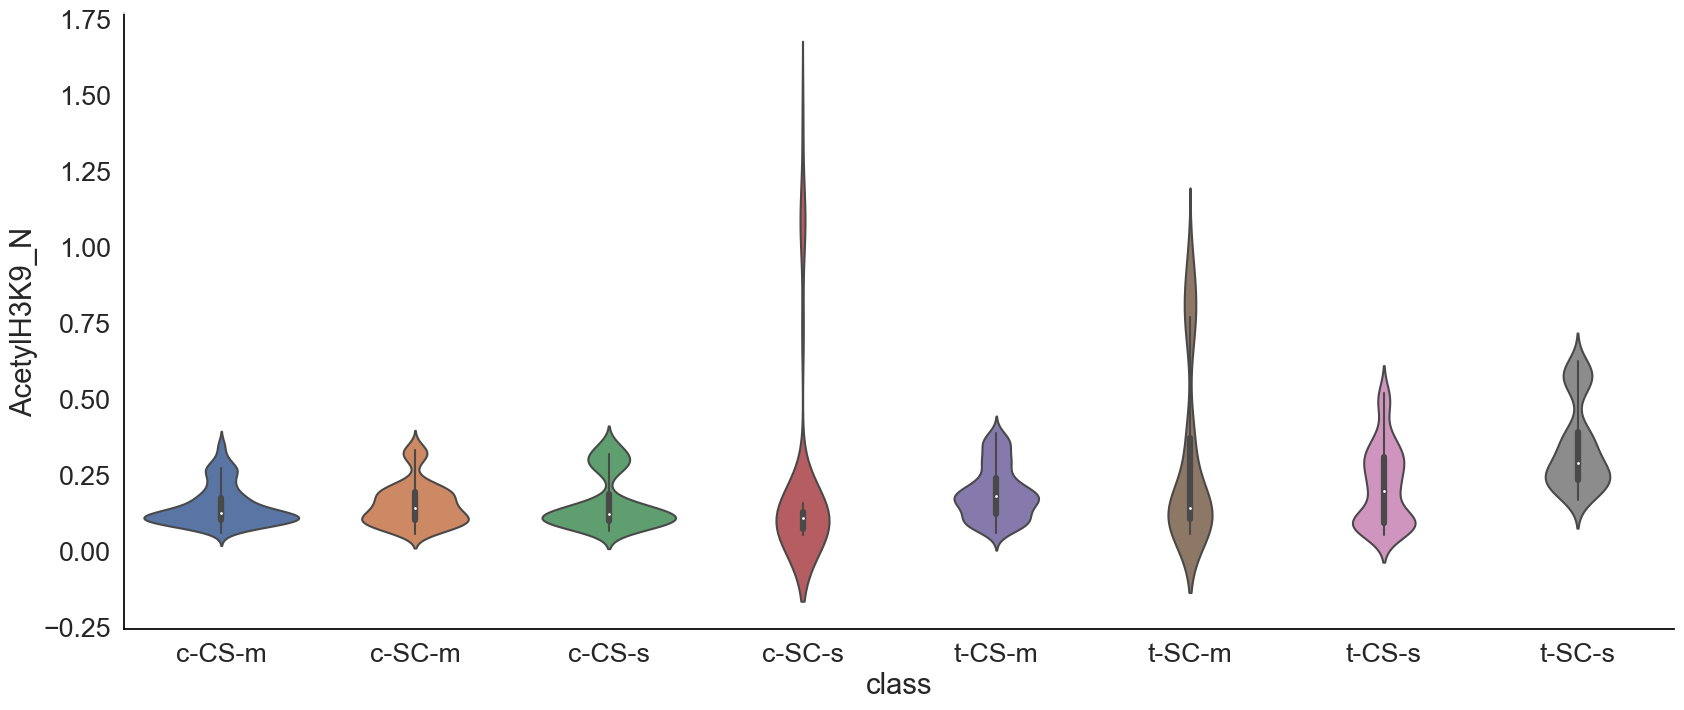

In [58]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='AcetylH3K9_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


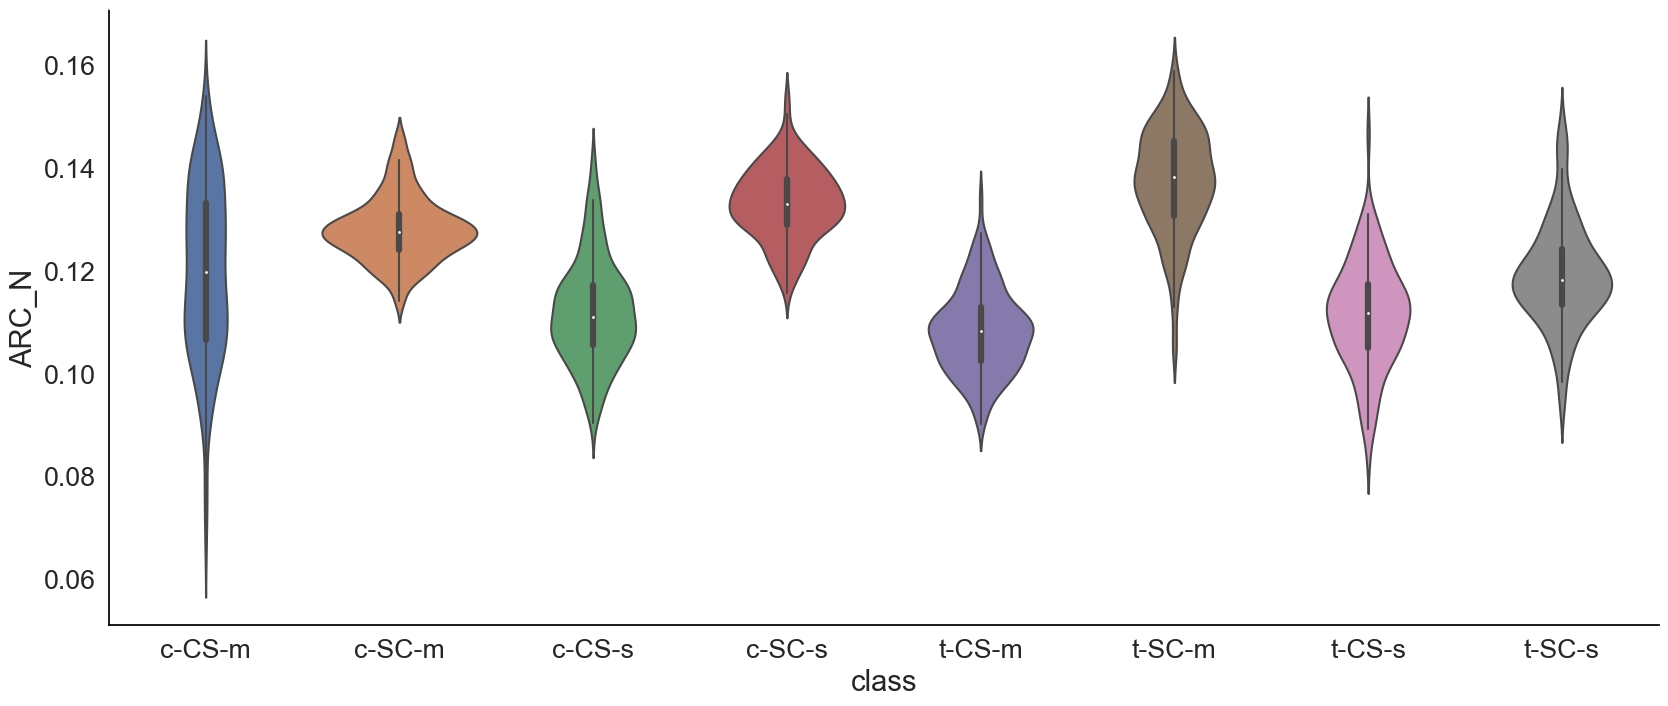

In [59]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='ARC_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


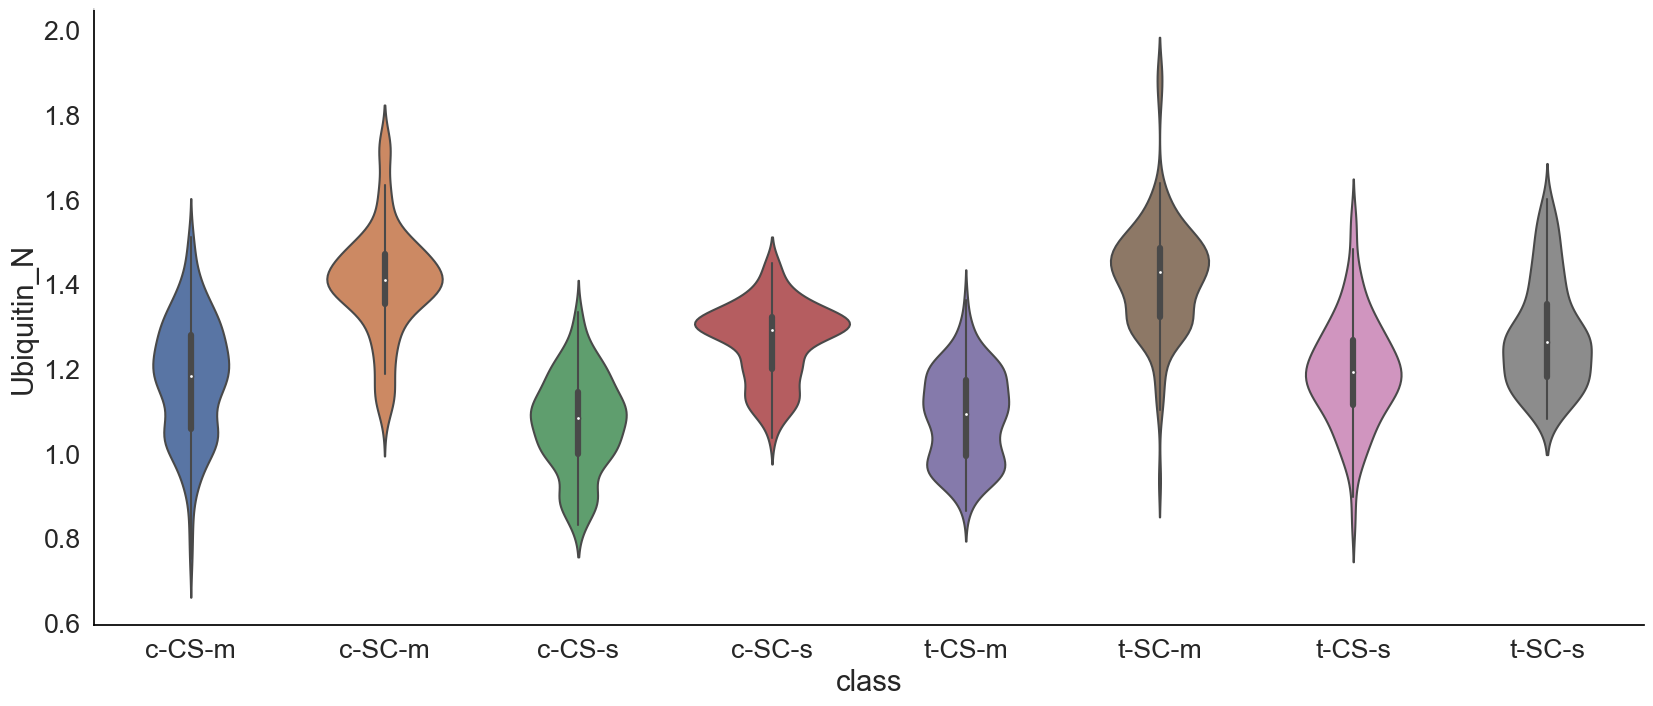

In [60]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='Ubiquitin_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


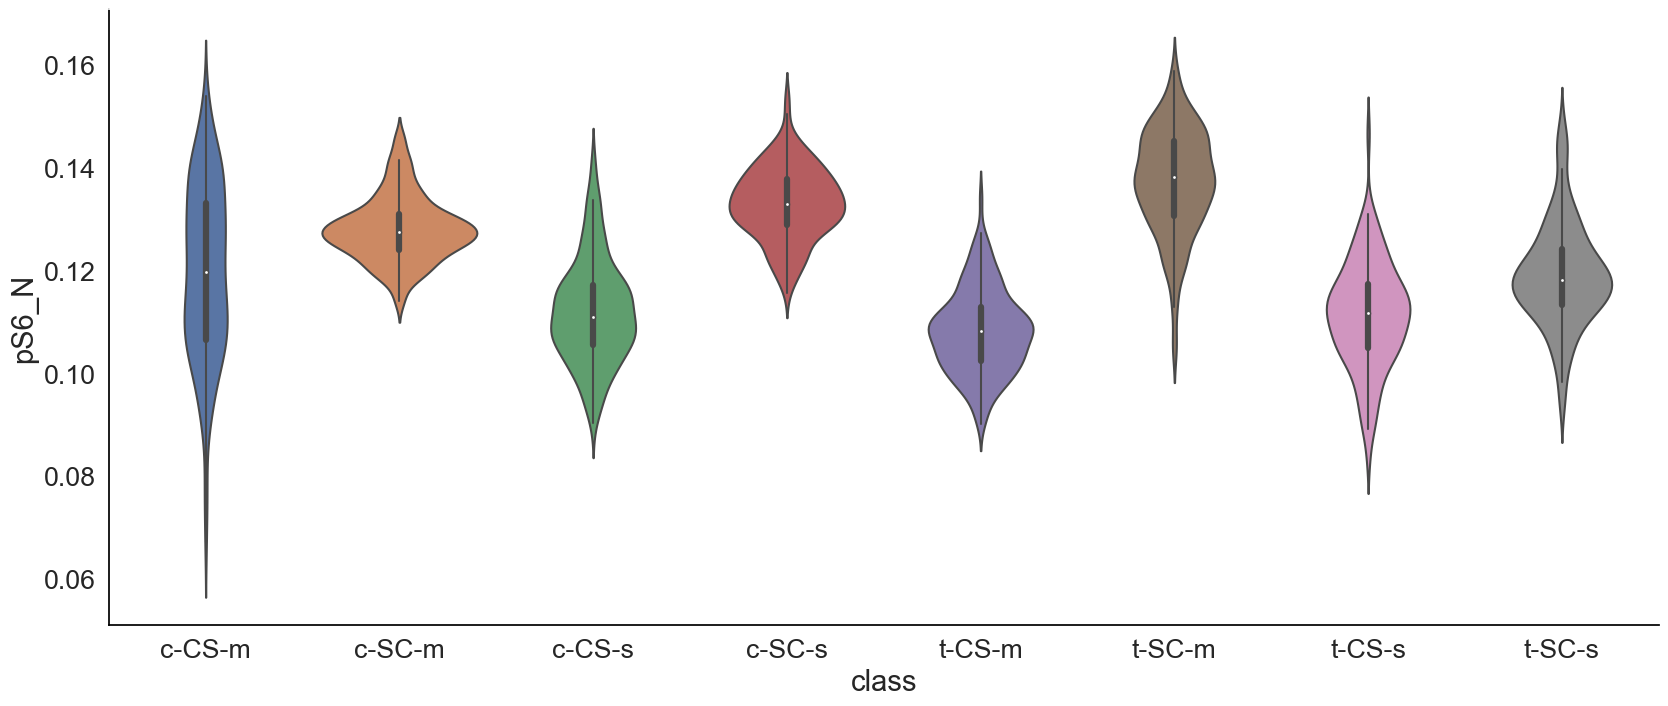

In [61]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='pS6_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jacobserfaty/opt/anaconda3/envs/new-learn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


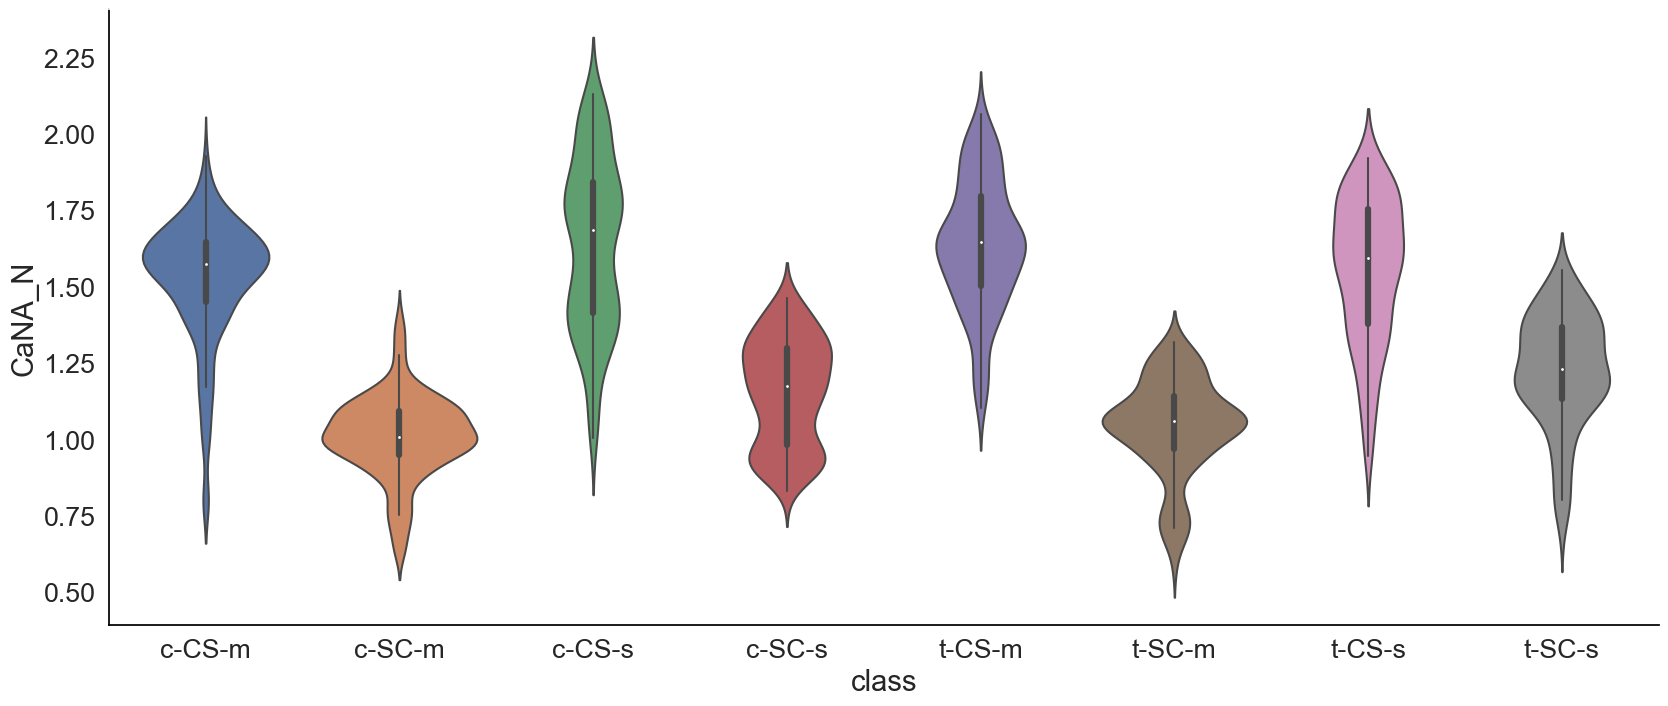

In [62]:
# Visualizing Protein Expression for important proteins
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('ticks')
sns.set(font_scale = 1.75)

g = sns.violinplot(
    y='CaNA_N',
    x='class',
    data = nmice)

g.set_facecolor('xkcd:white')
g.spines['left'].set_color('black')
g.spines['bottom'].set_color('black')


## KMeans Clustering

In [63]:
# # Perform KMeans clustering
# kmeans = KMeans(n_clusters=5, random_state=42)
# cluster_labels = kmeans.fit_predict(X)
# cluster_centers = kmeans.cluster_centers_


In [64]:
# # Add cluster labels as a new feature
# X_clusters = np.hstack((X, cluster_labels.reshape(-1, 1)))

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_clusters, y, test_size=0.3, random_state=42)

# # Train a RandomForestClassifier
# clf_kmean = RandomForestClassifier(random_state=42)
# clf_kmean.fit(X_train, y_train)

# # Predict on the test set
# y_pred = clf_kmean.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


In [65]:
# # Visualize the KMeans clusters
# plt.figure(figsize = (10, 6))

# # Plot data points colored by cluster labels
# plt.scatter(X.iloc[:, 0], X.iloc[:, 4], c=cluster_labels, cmap='viridis', s=50, alpha=0.5)

# # Plot cluster centers
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 4], c='red', marker='x', s=100, label='Cluster Centers')

# plt.title('KMeans Clustering Visualization')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.show()
